In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

In [3]:
config = f"""
execution:
    exp_id: exp_018
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [4]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv")
labels.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


  0%|          | 0/277 [00:00<?, ?it/s]

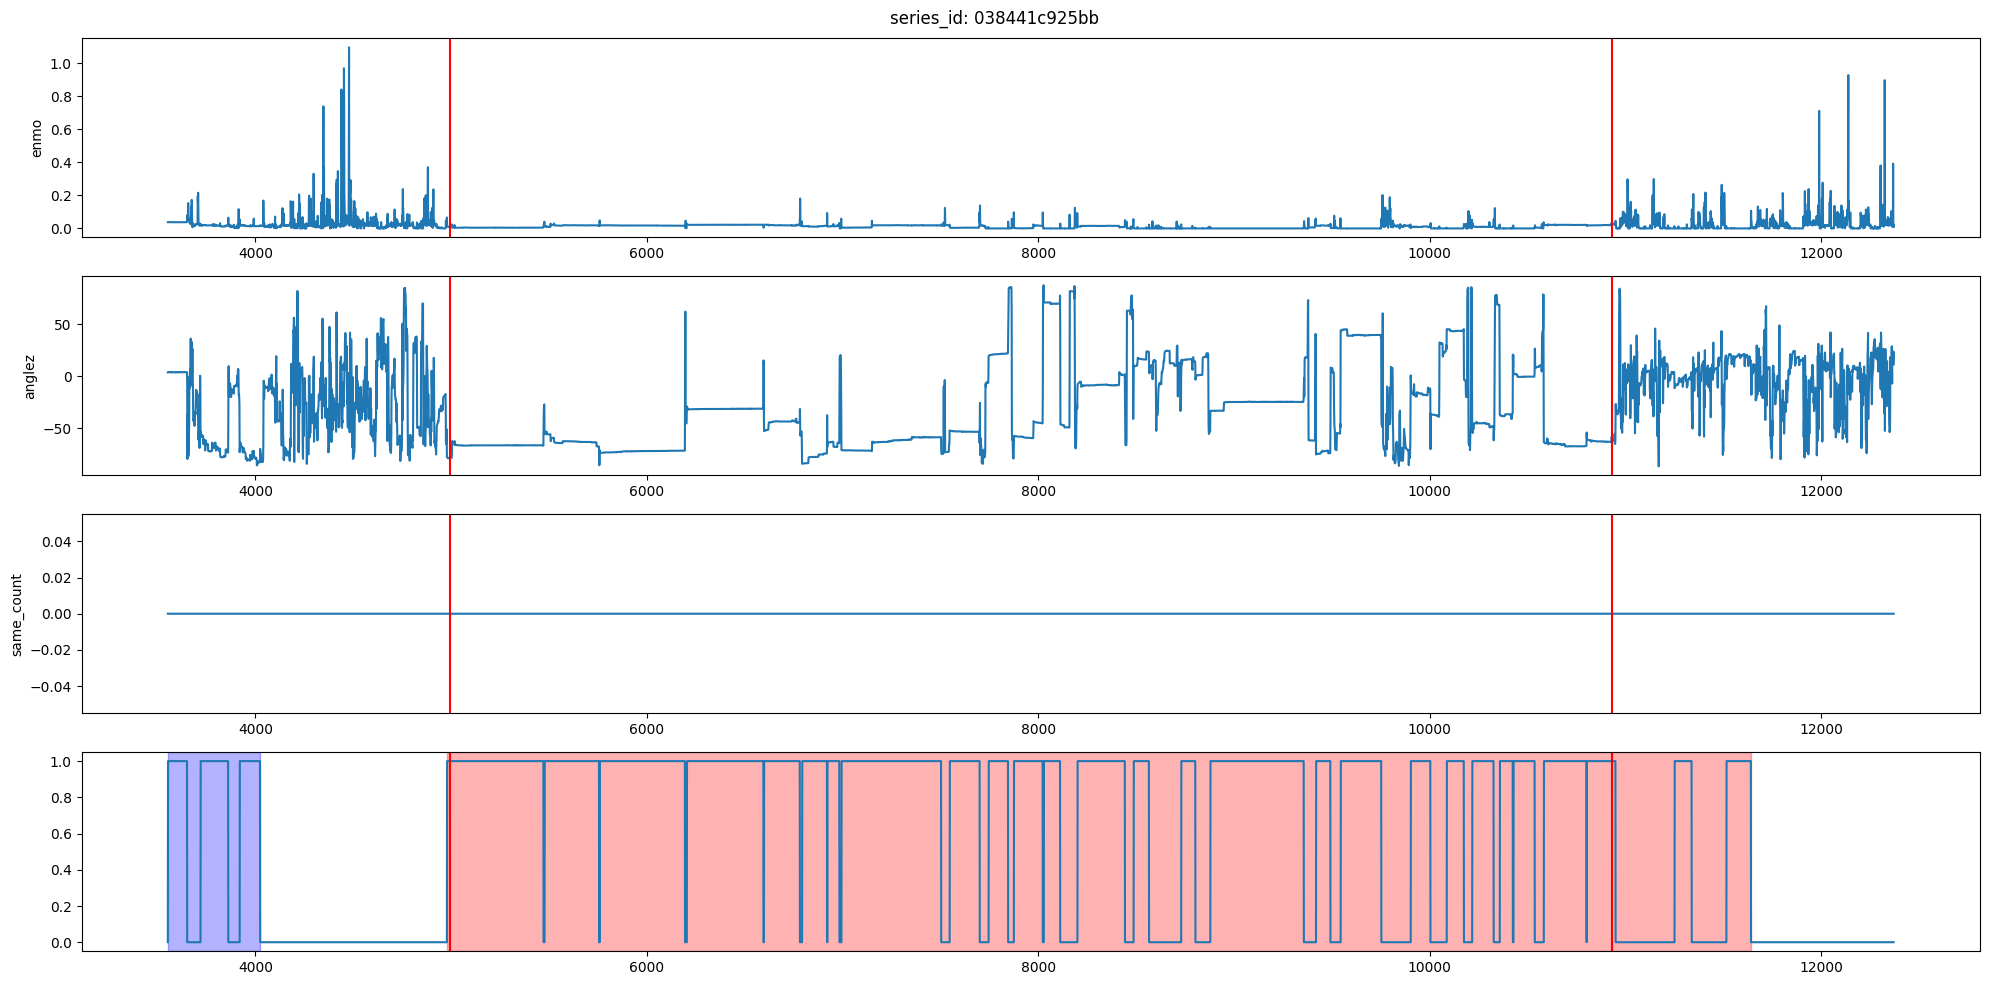

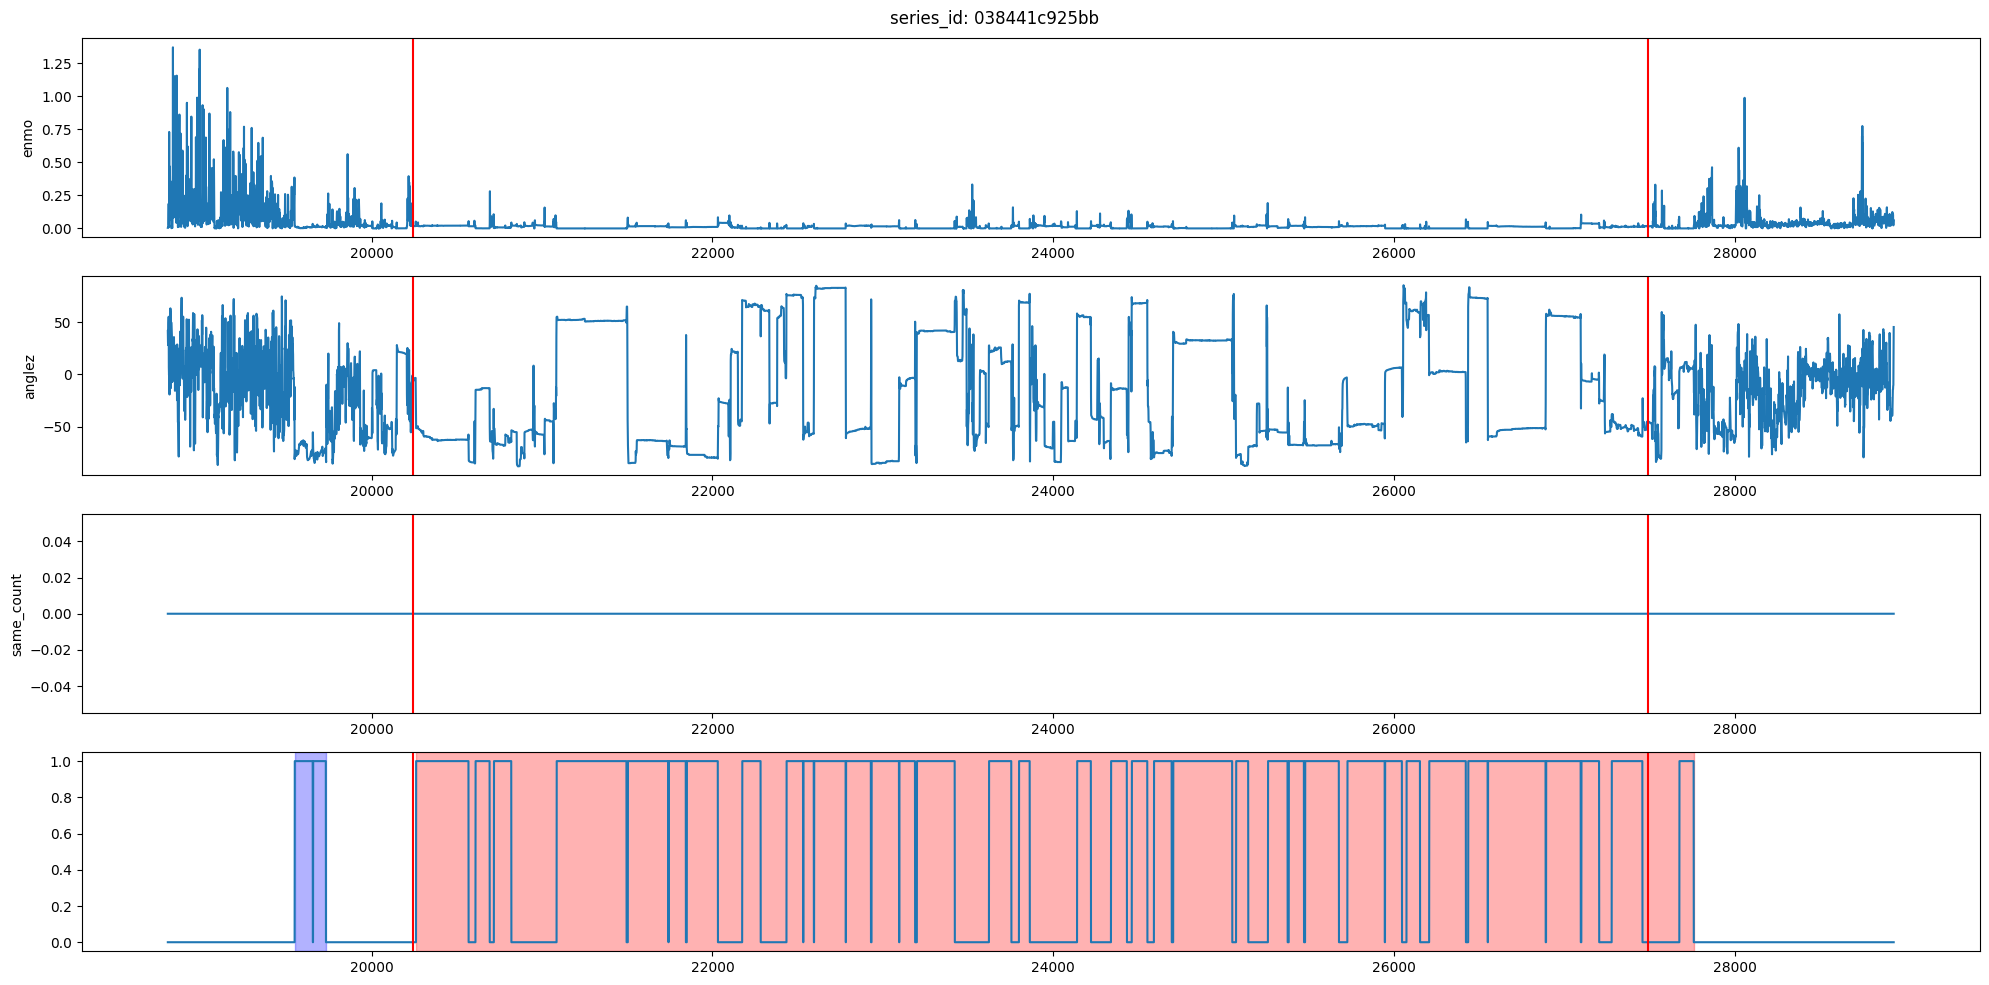

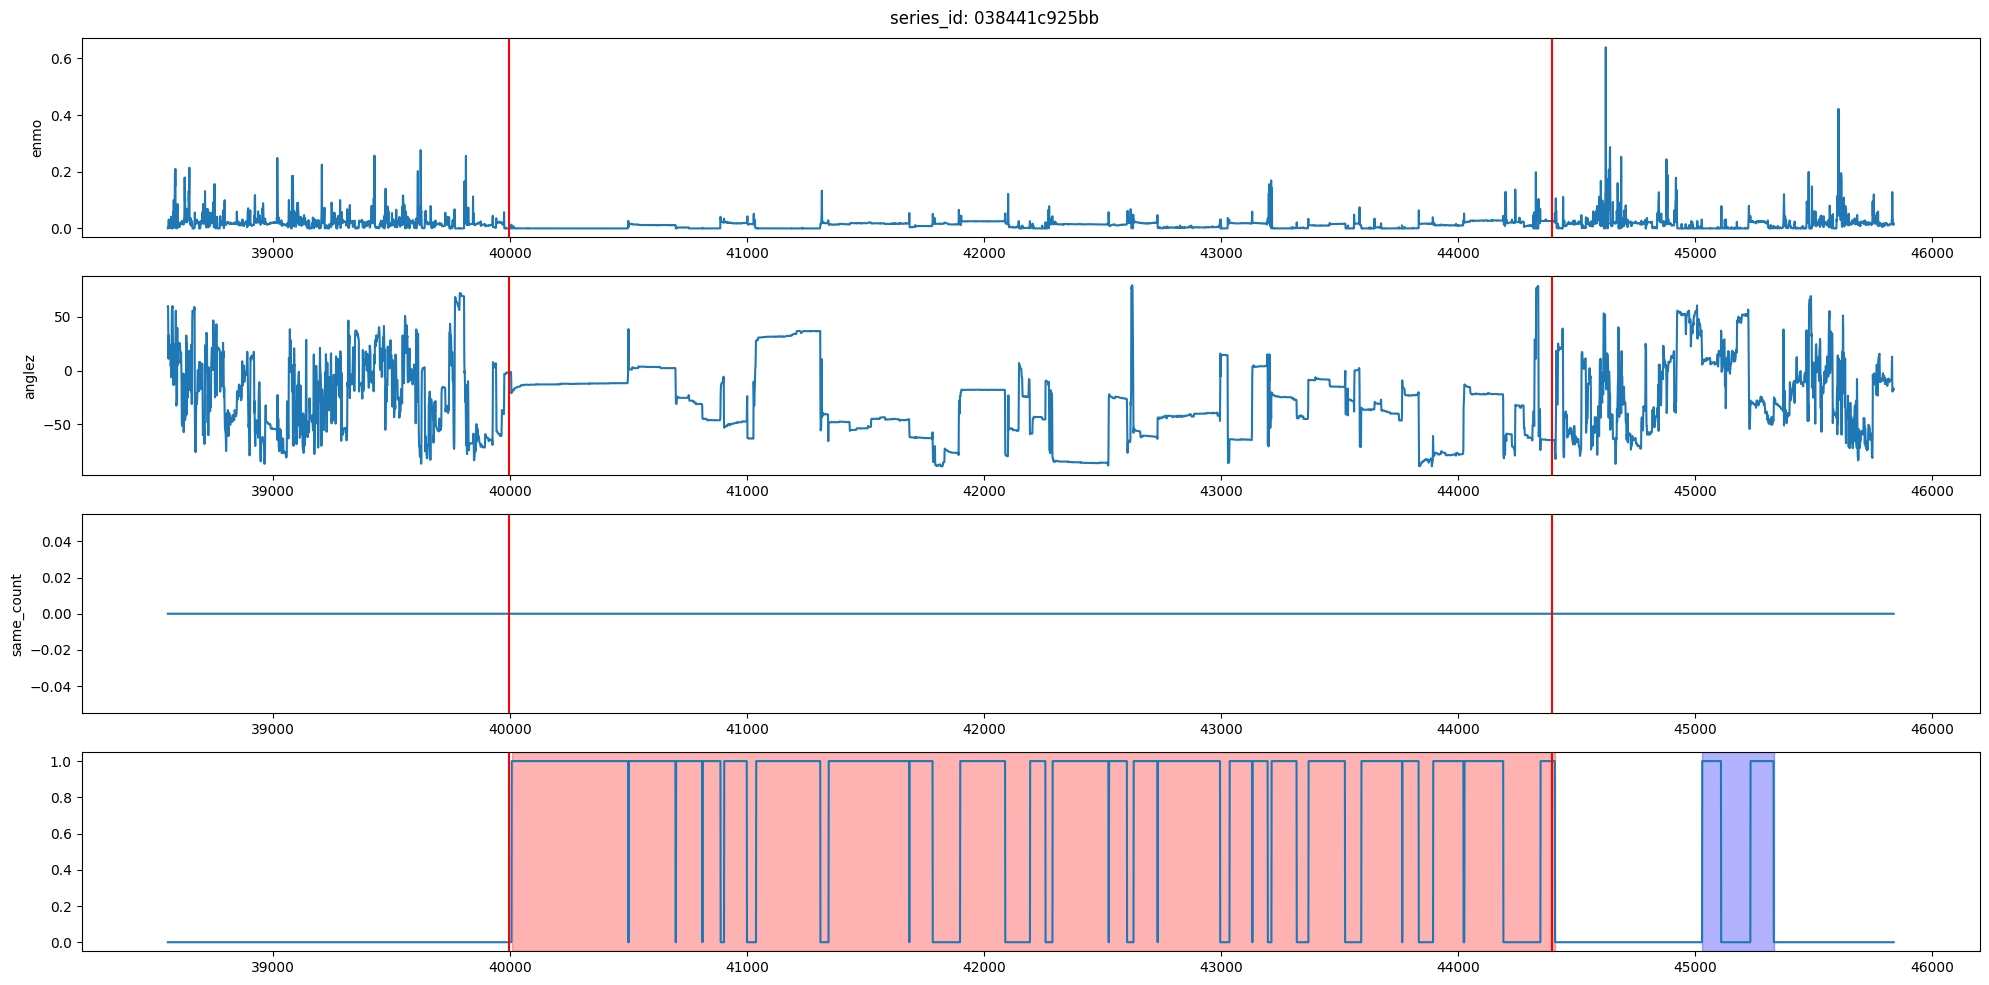

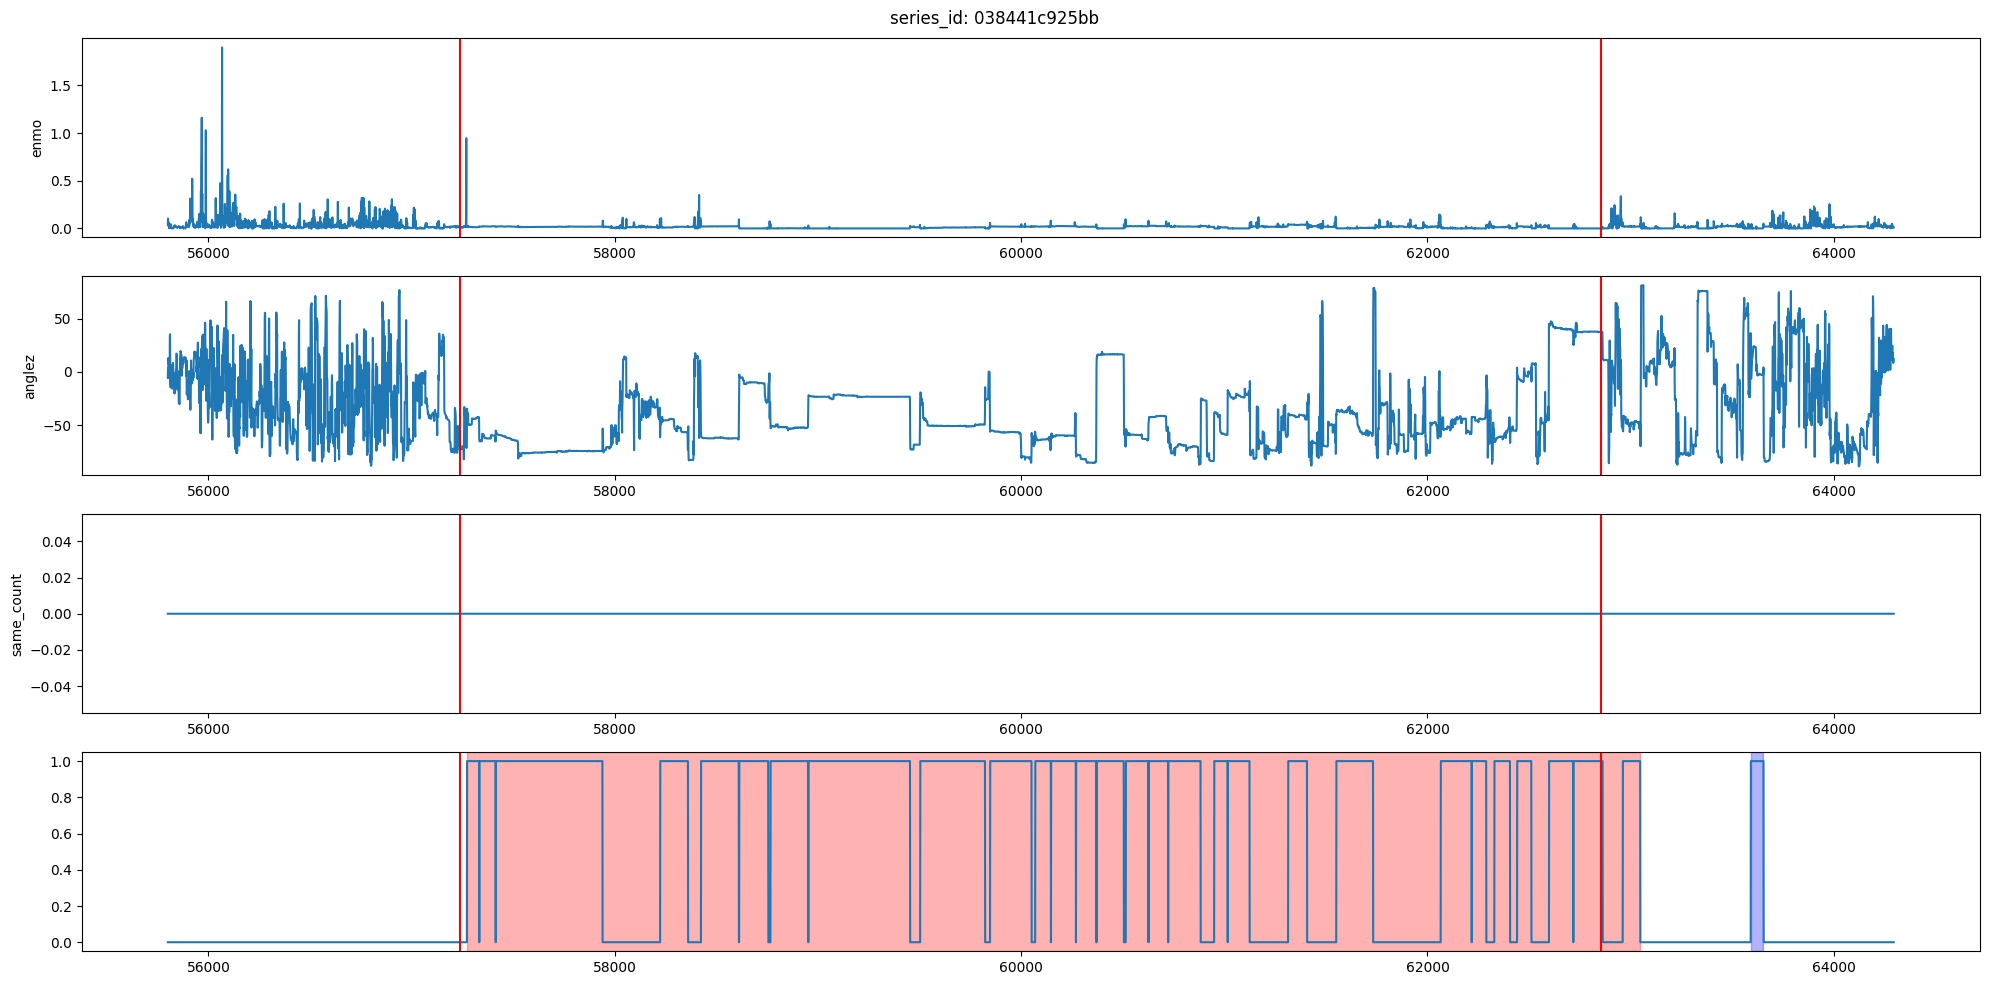

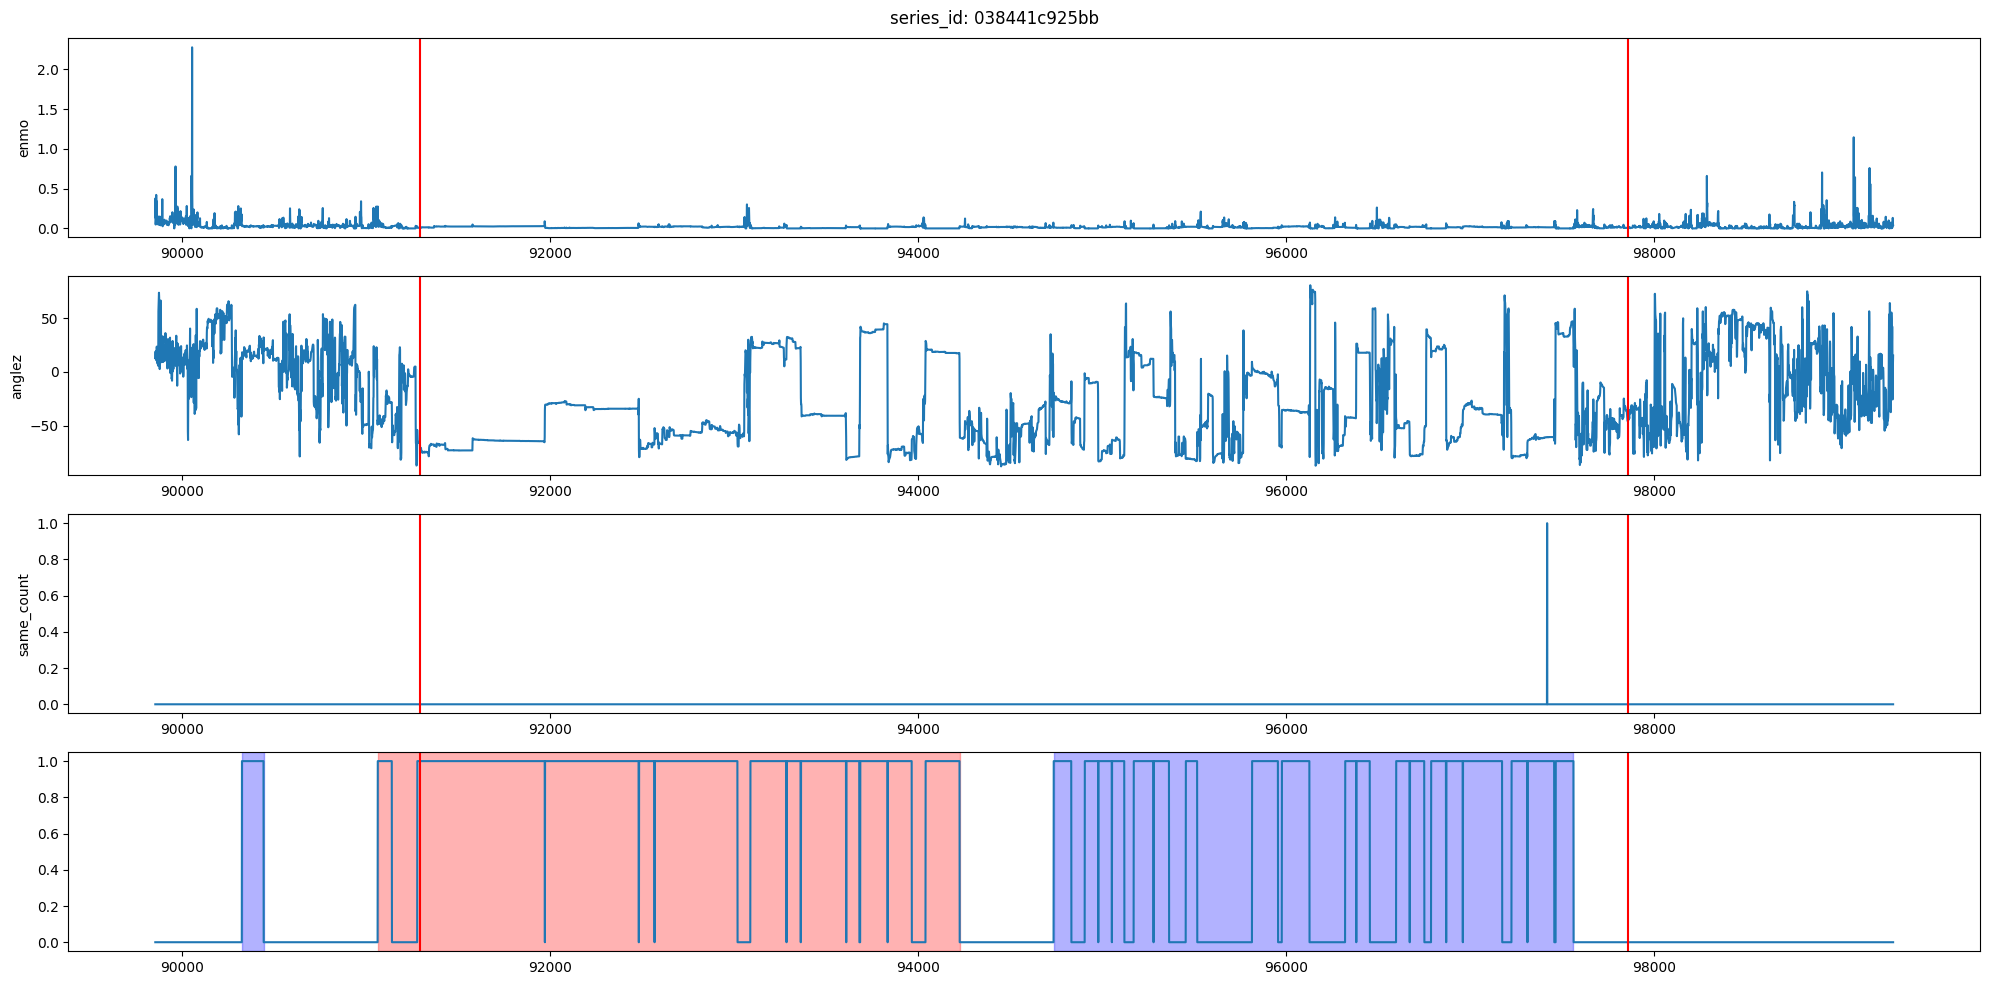

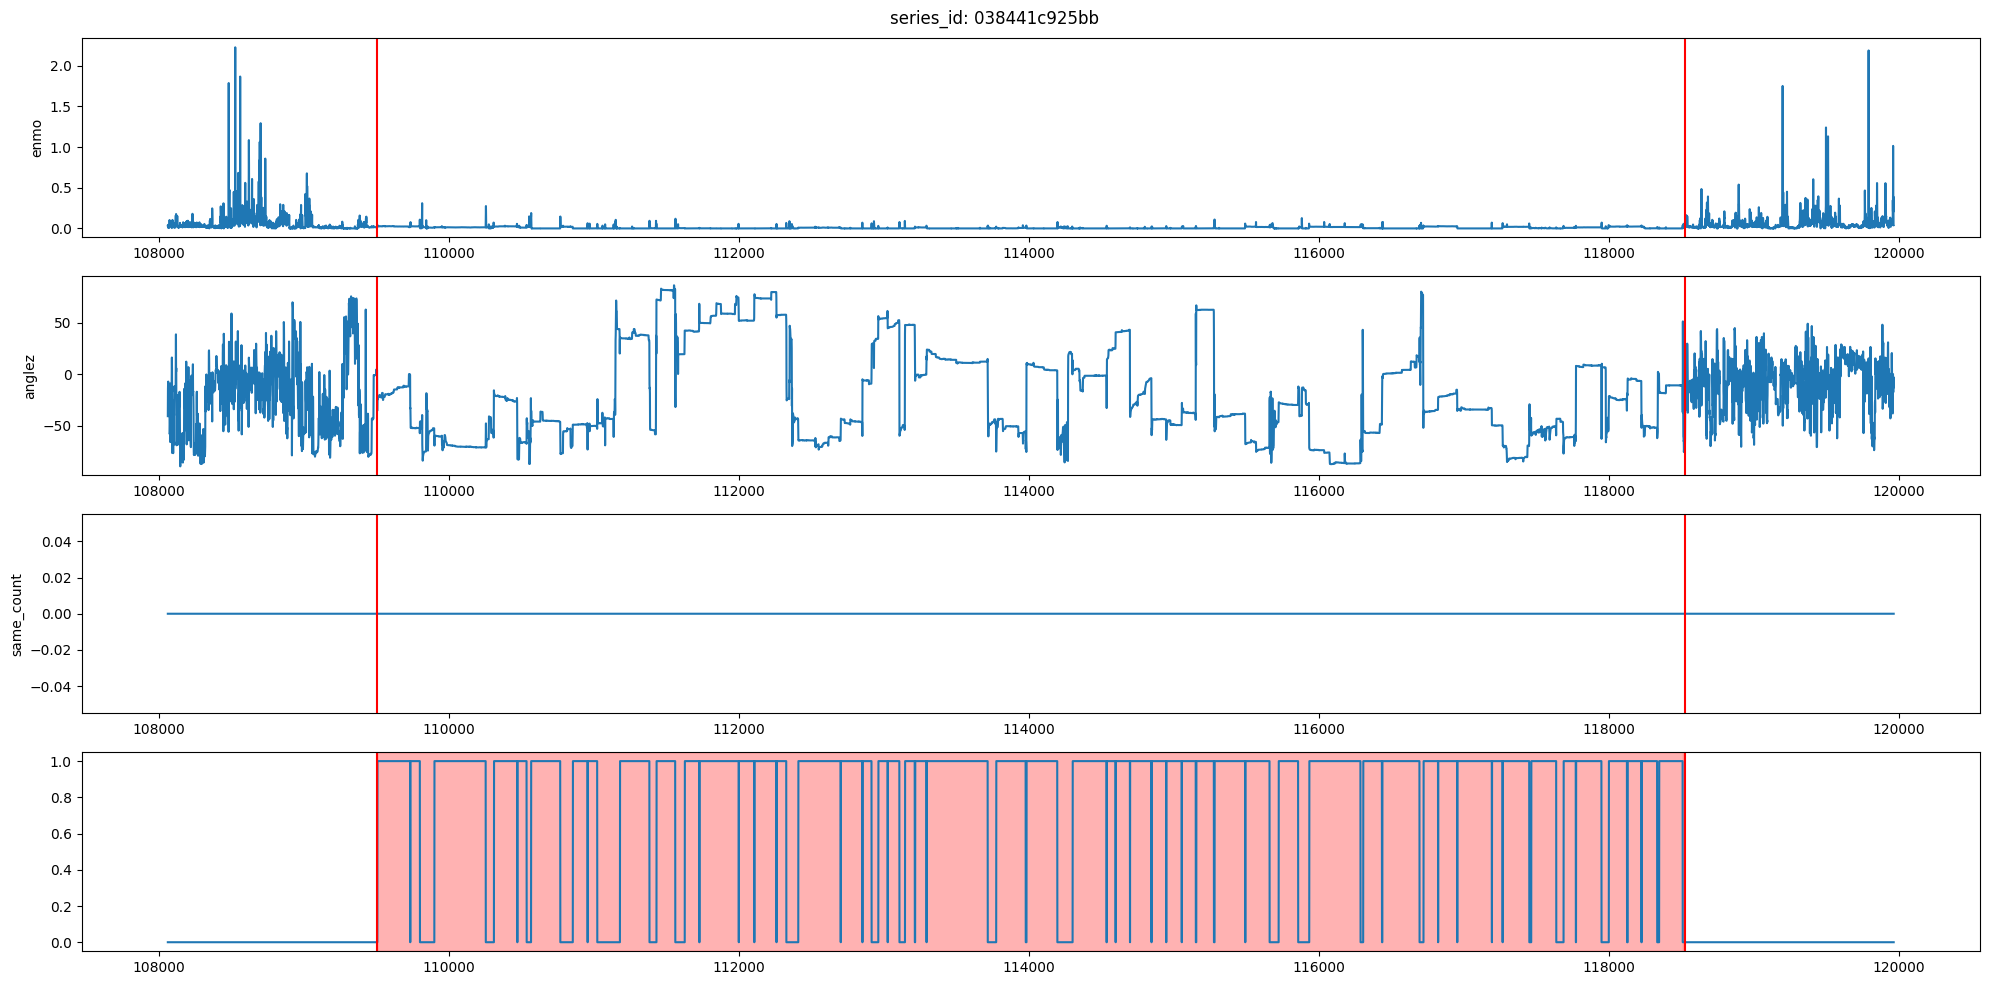

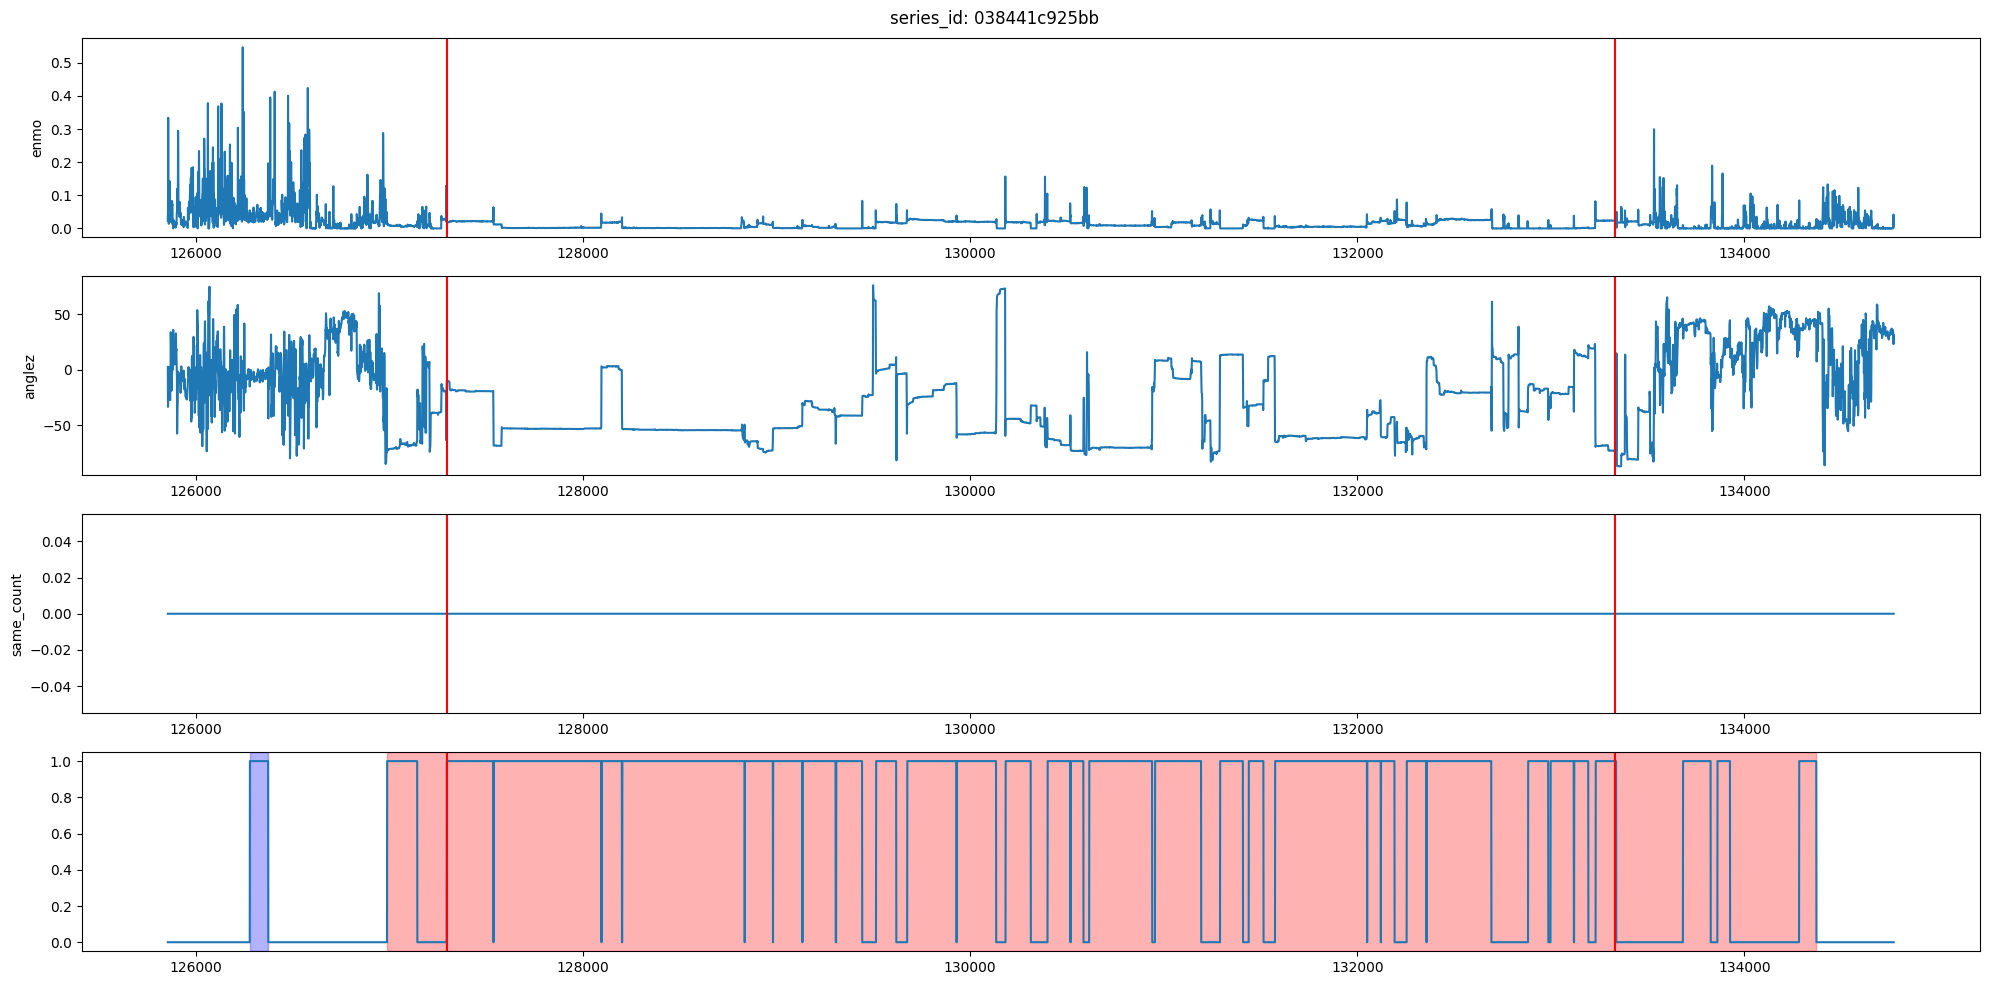

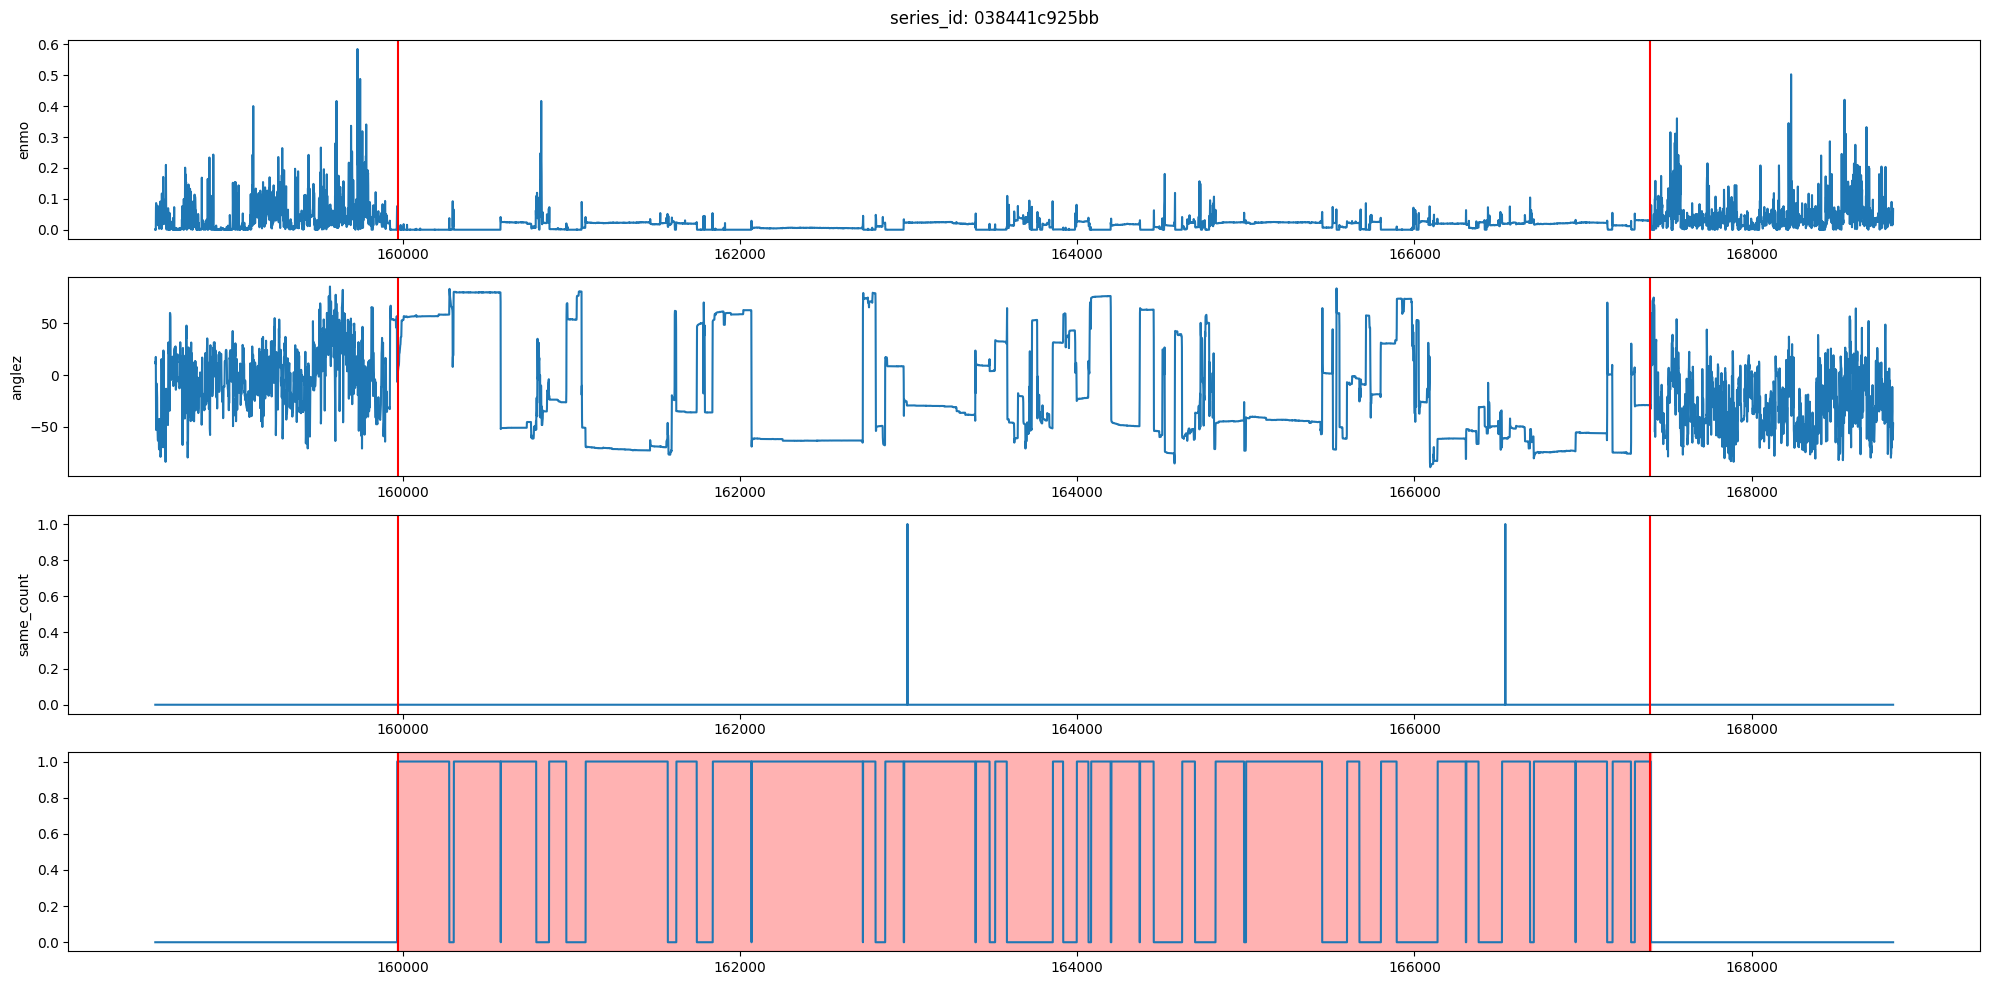

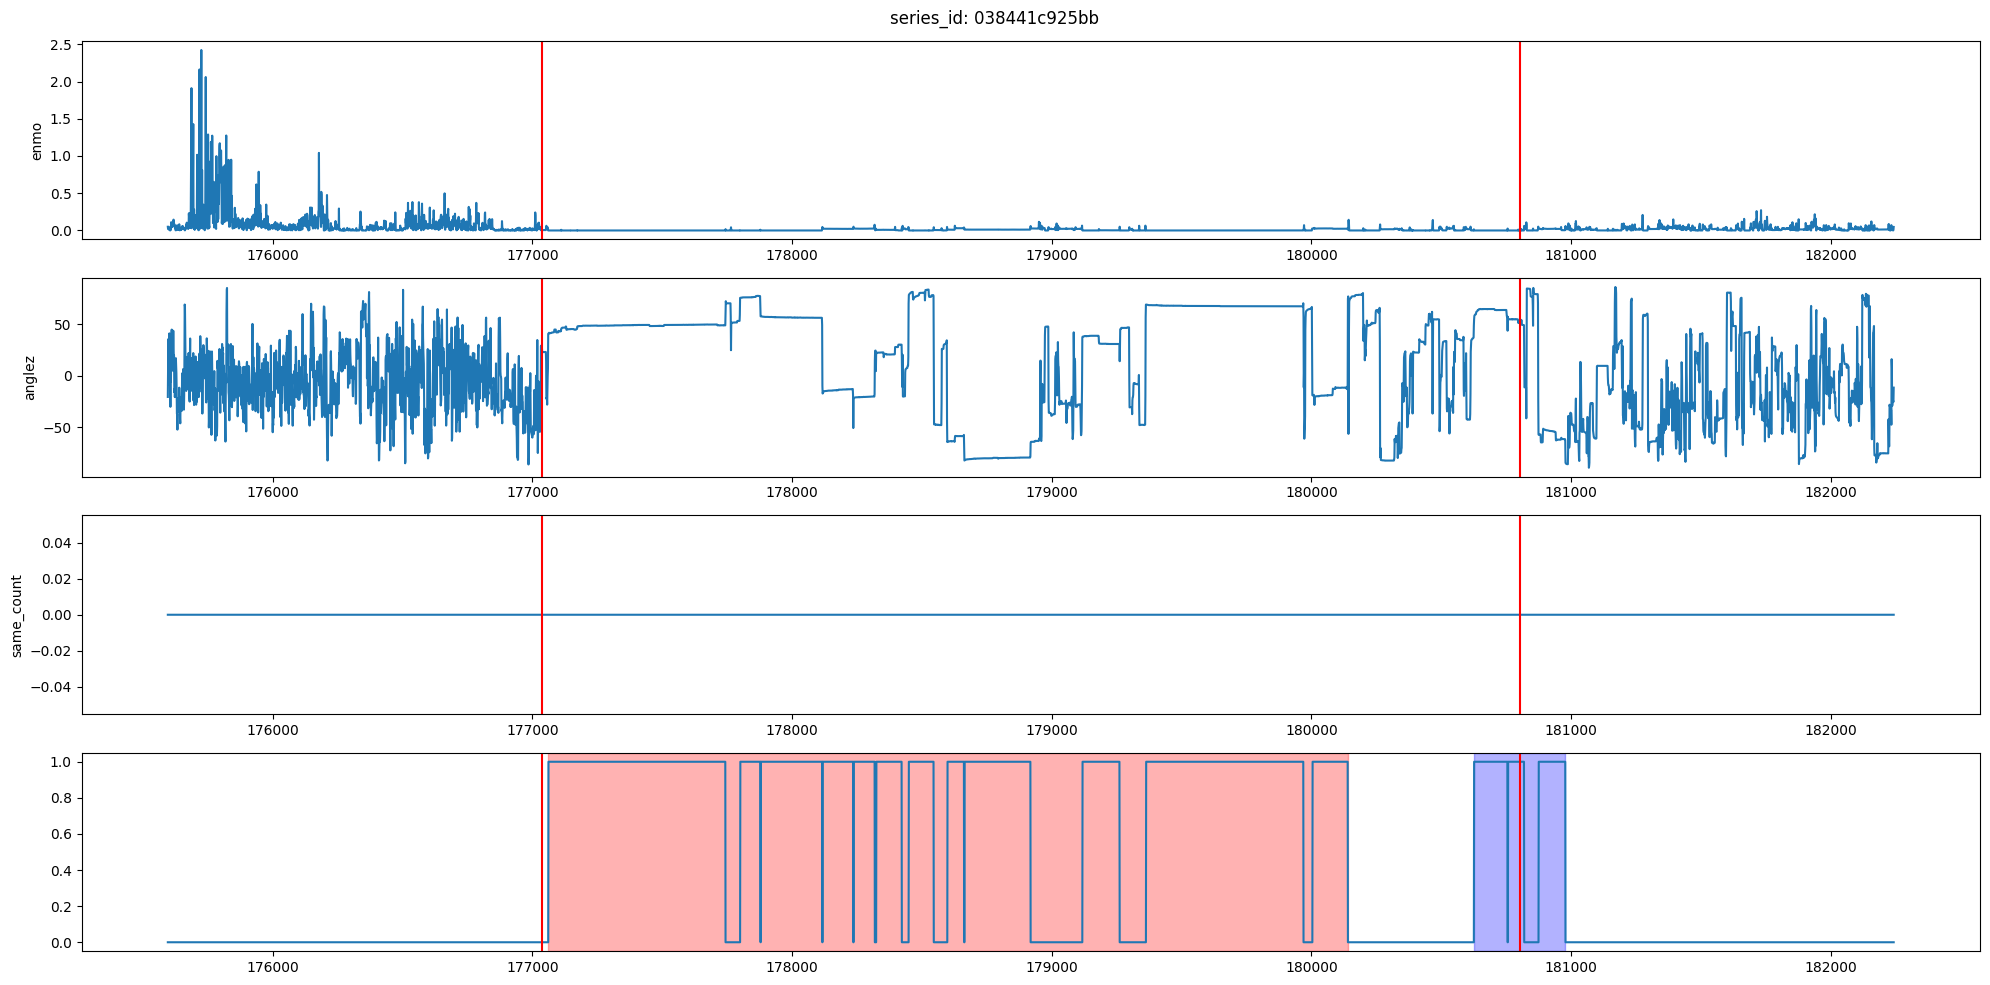

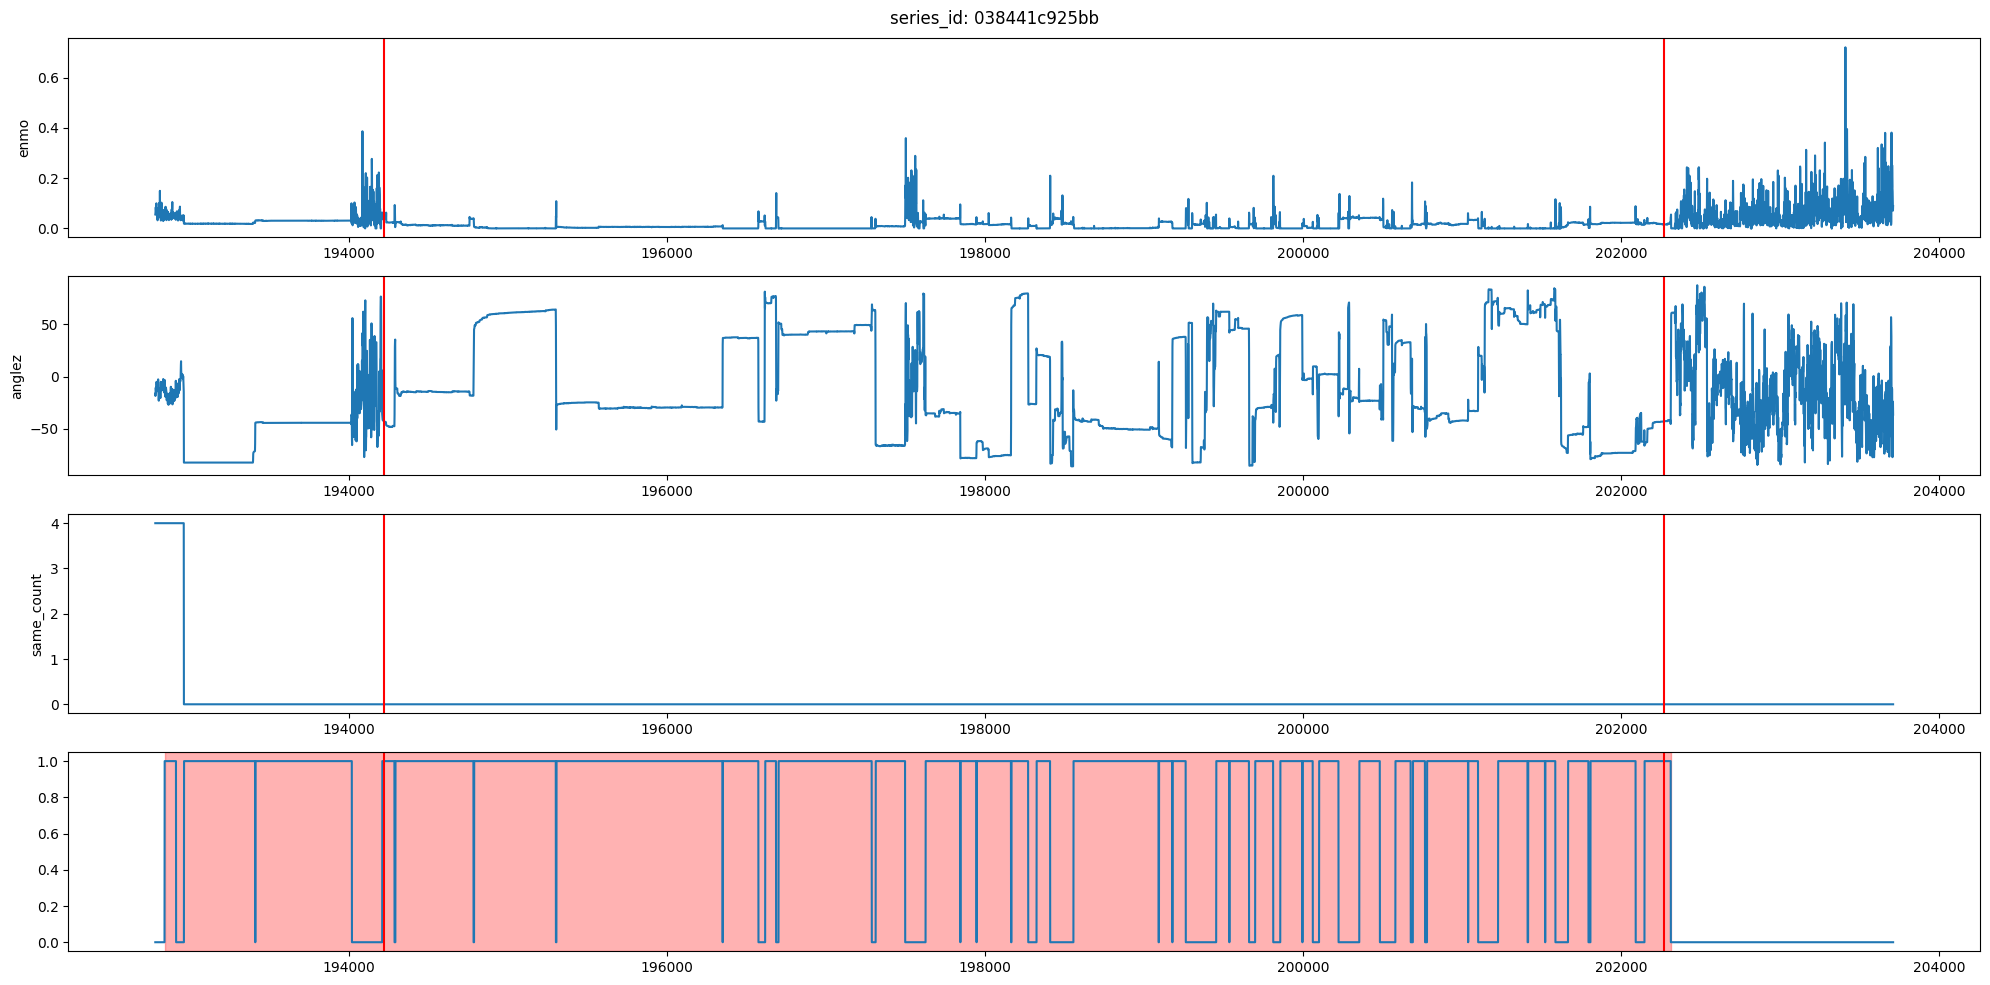

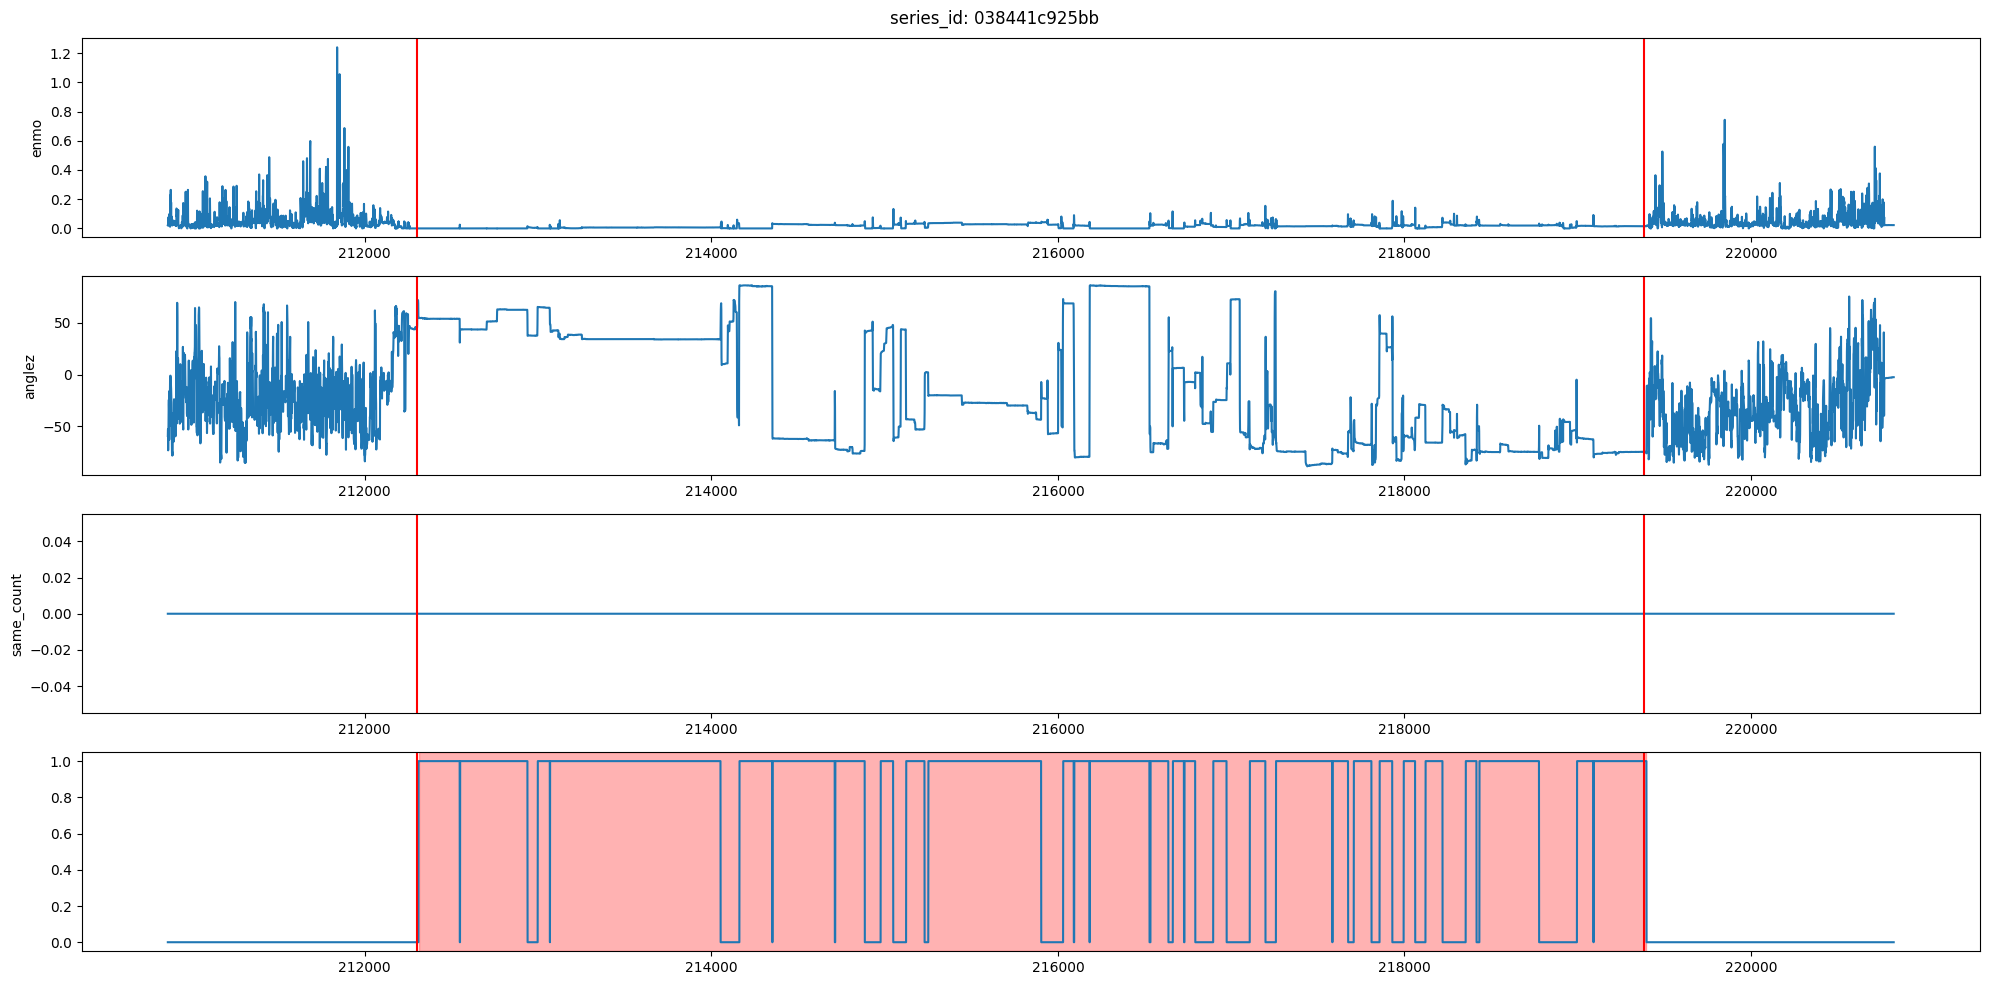

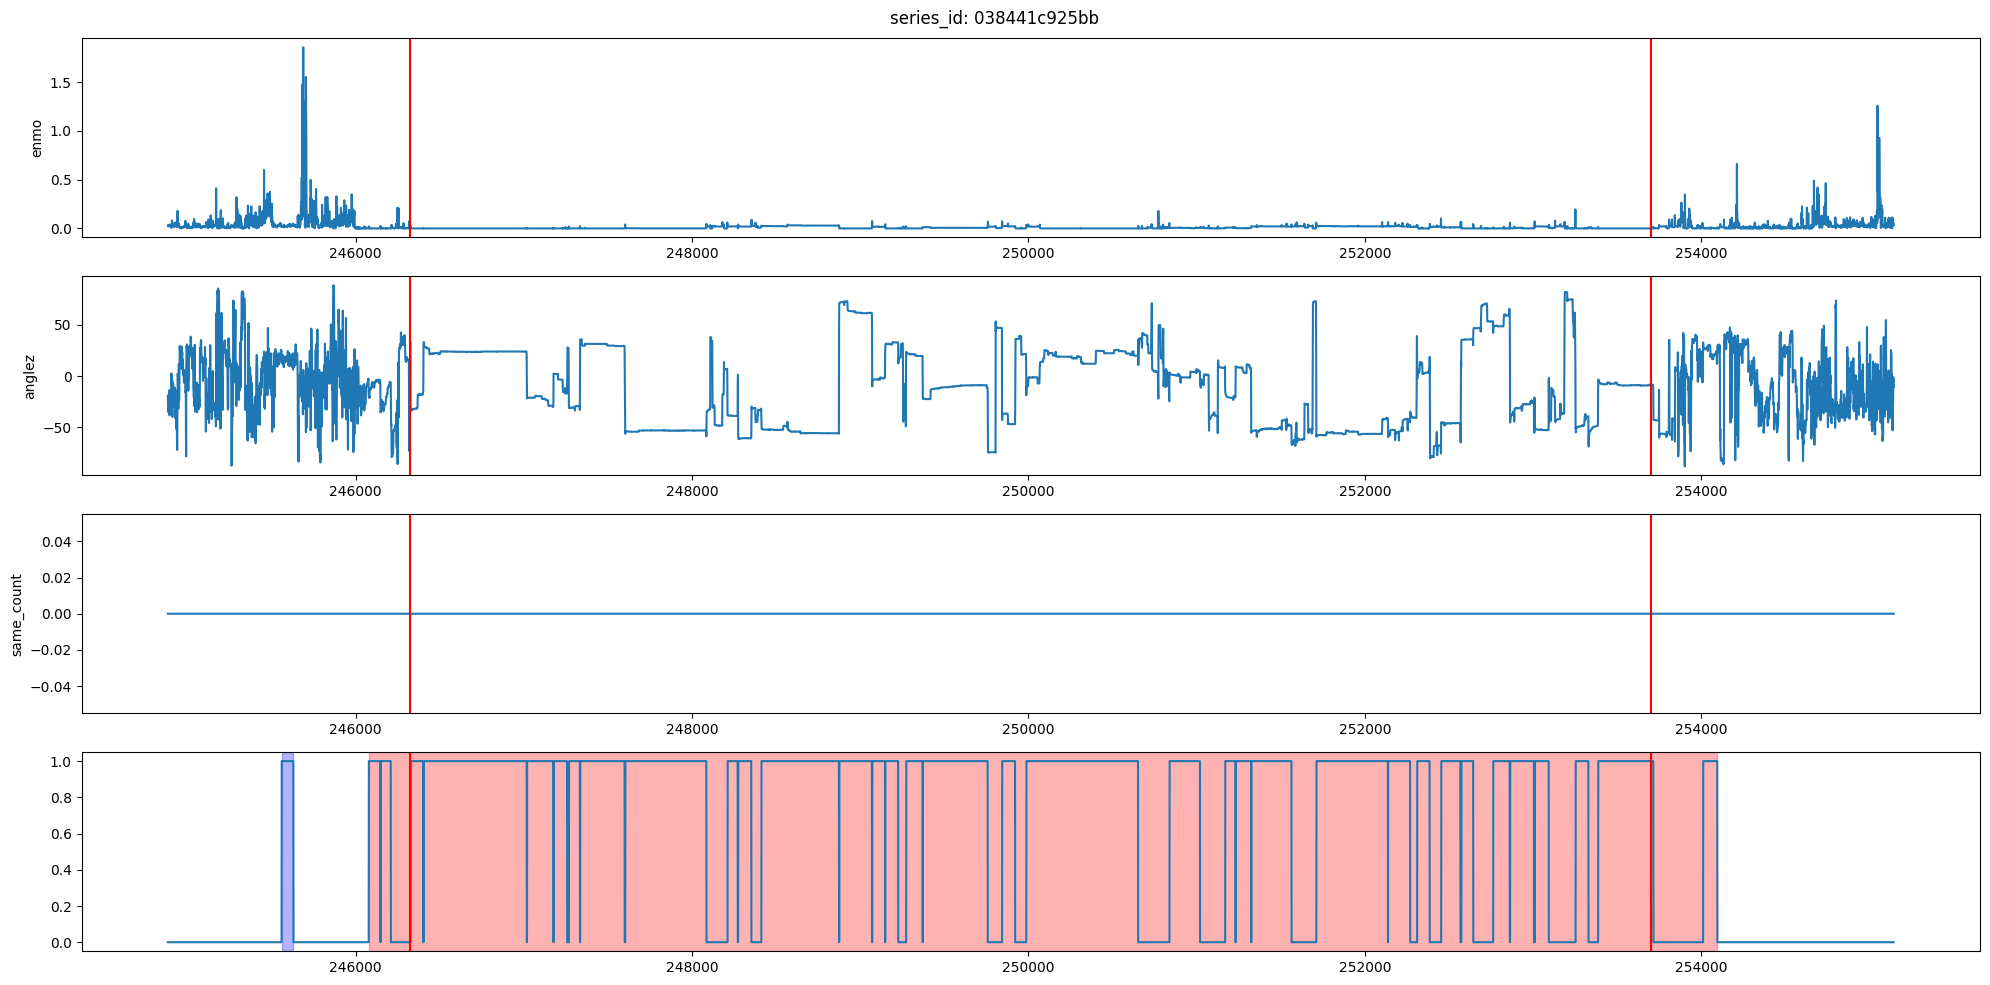

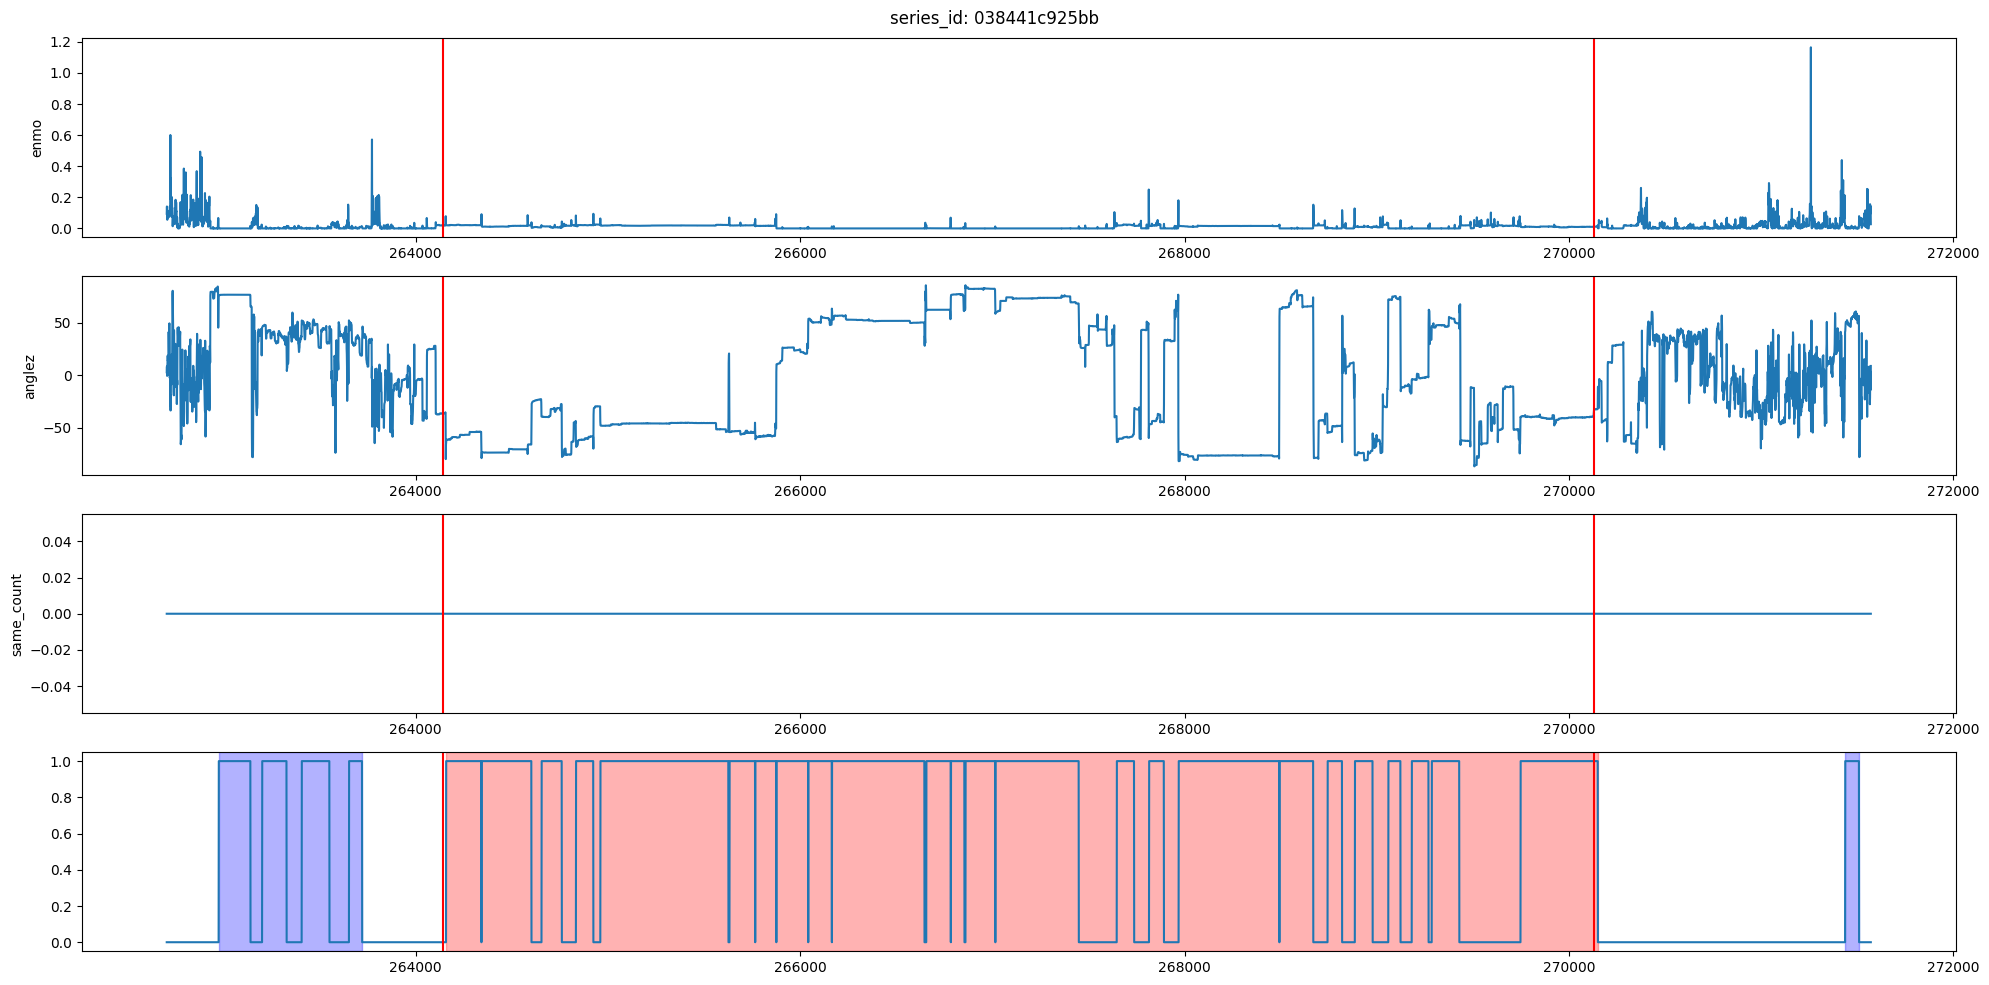

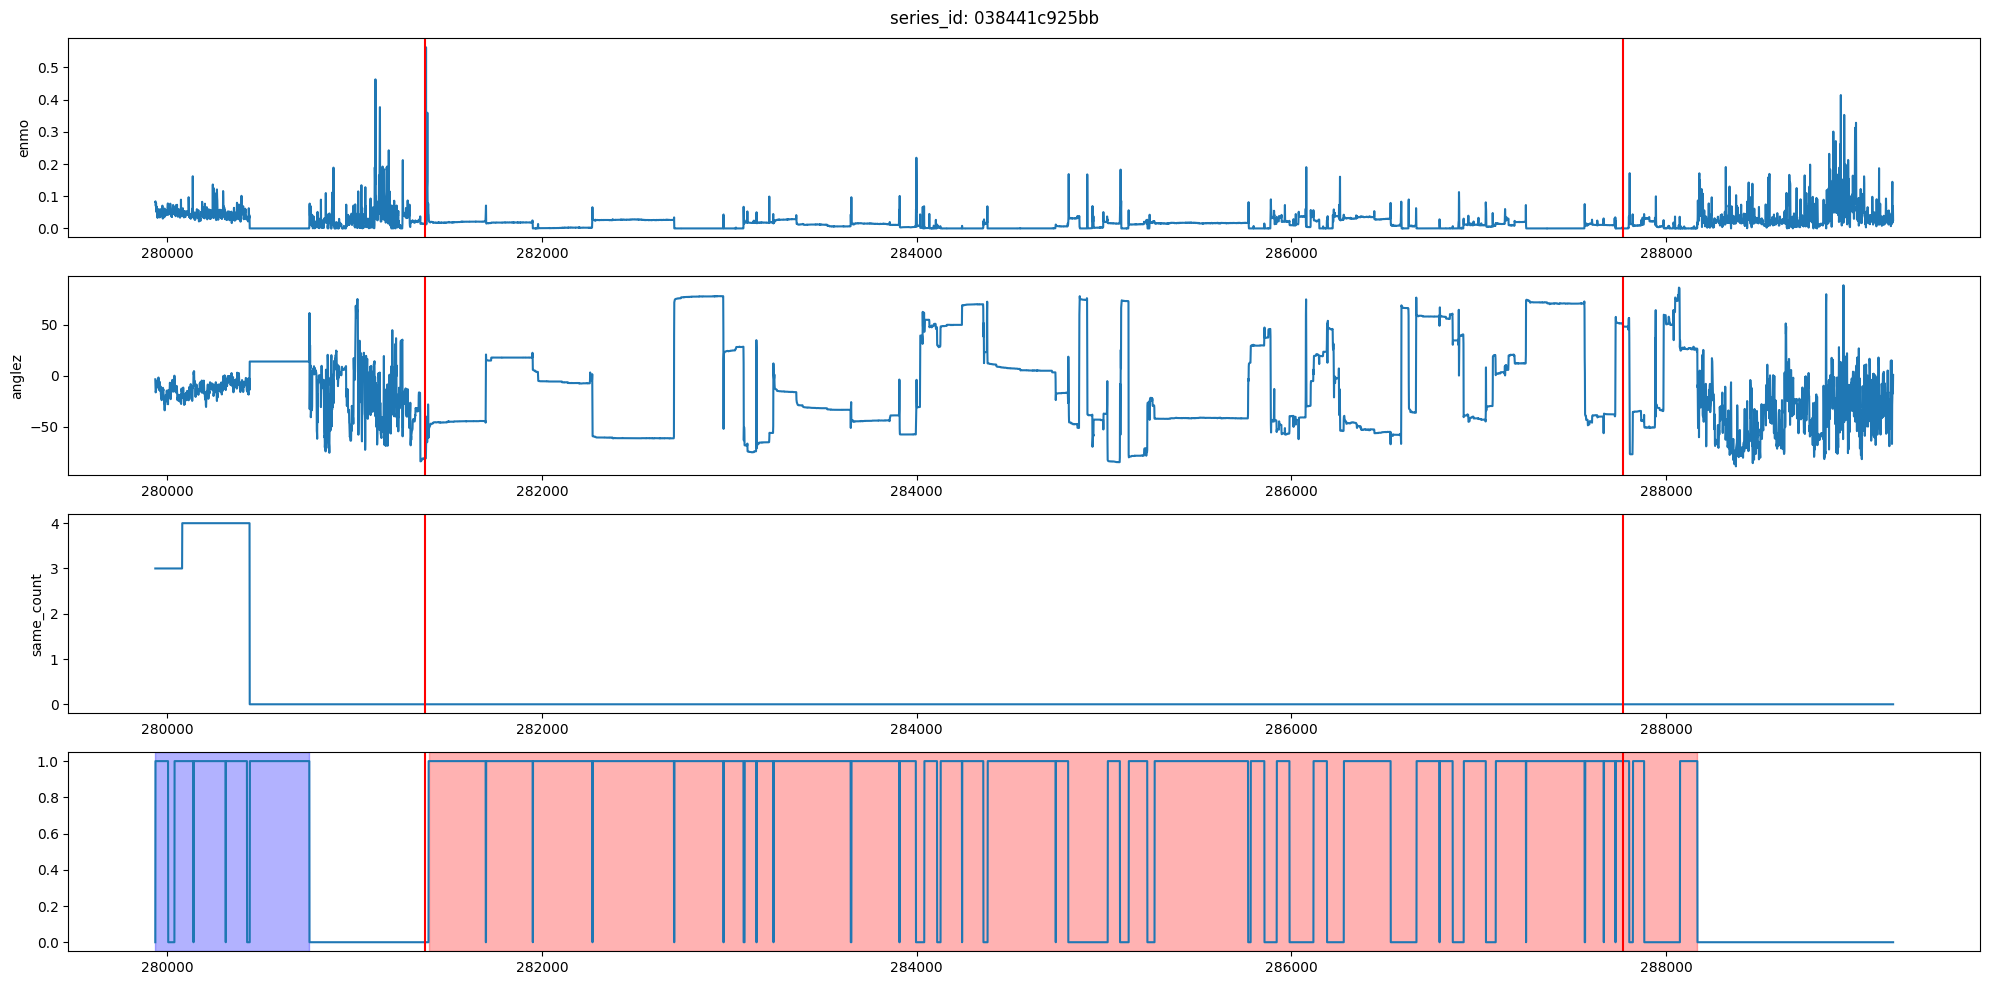

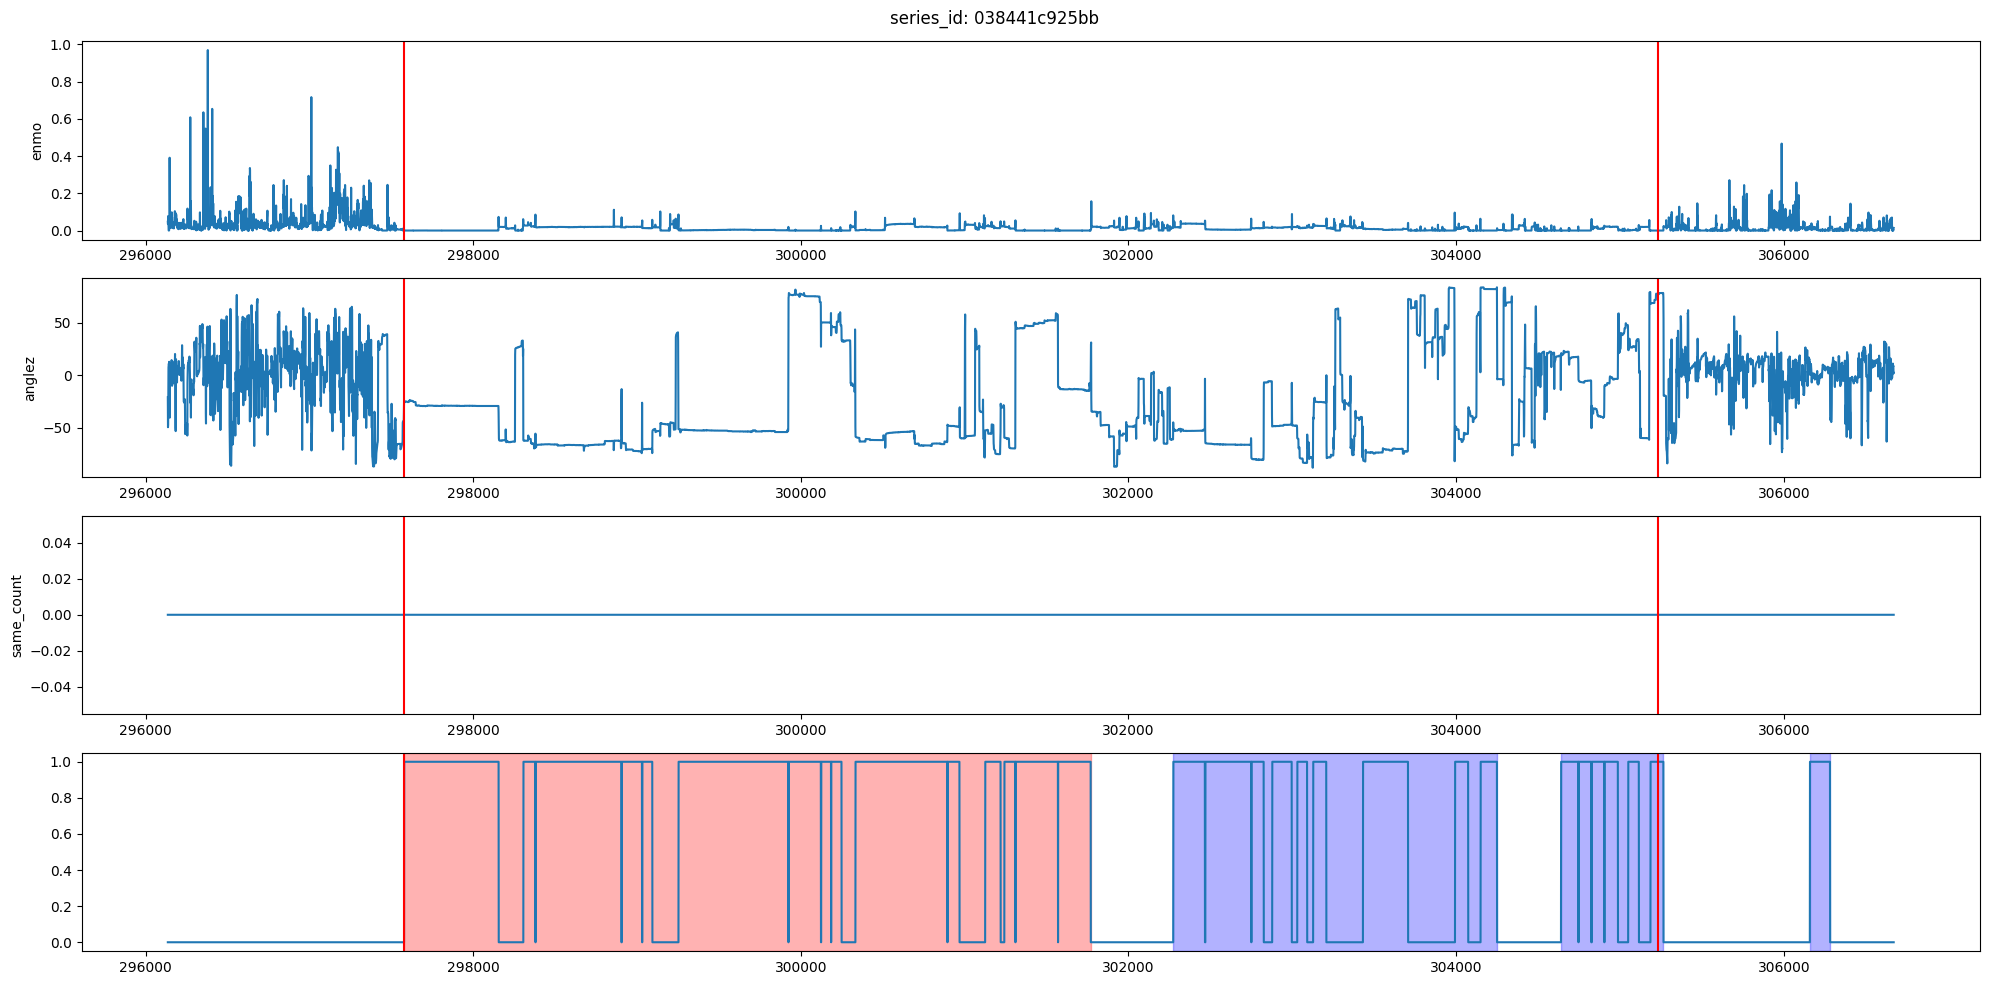

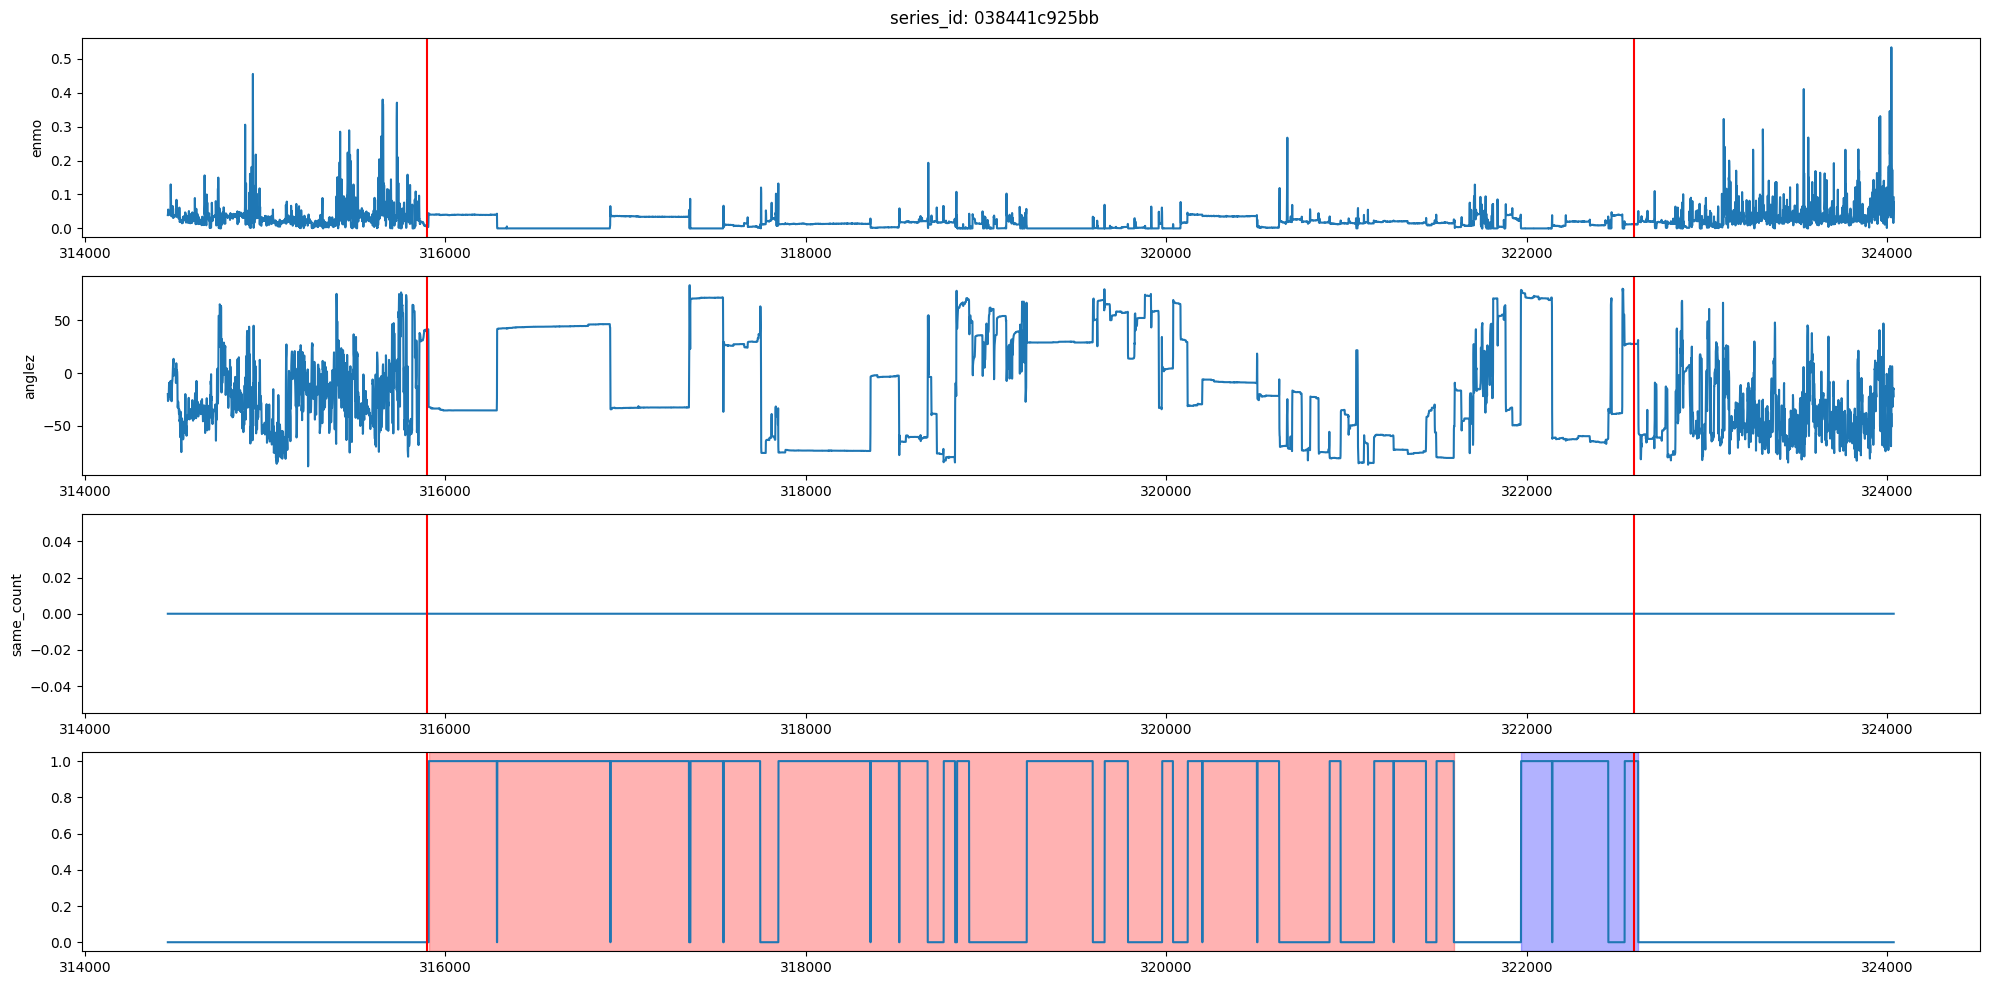

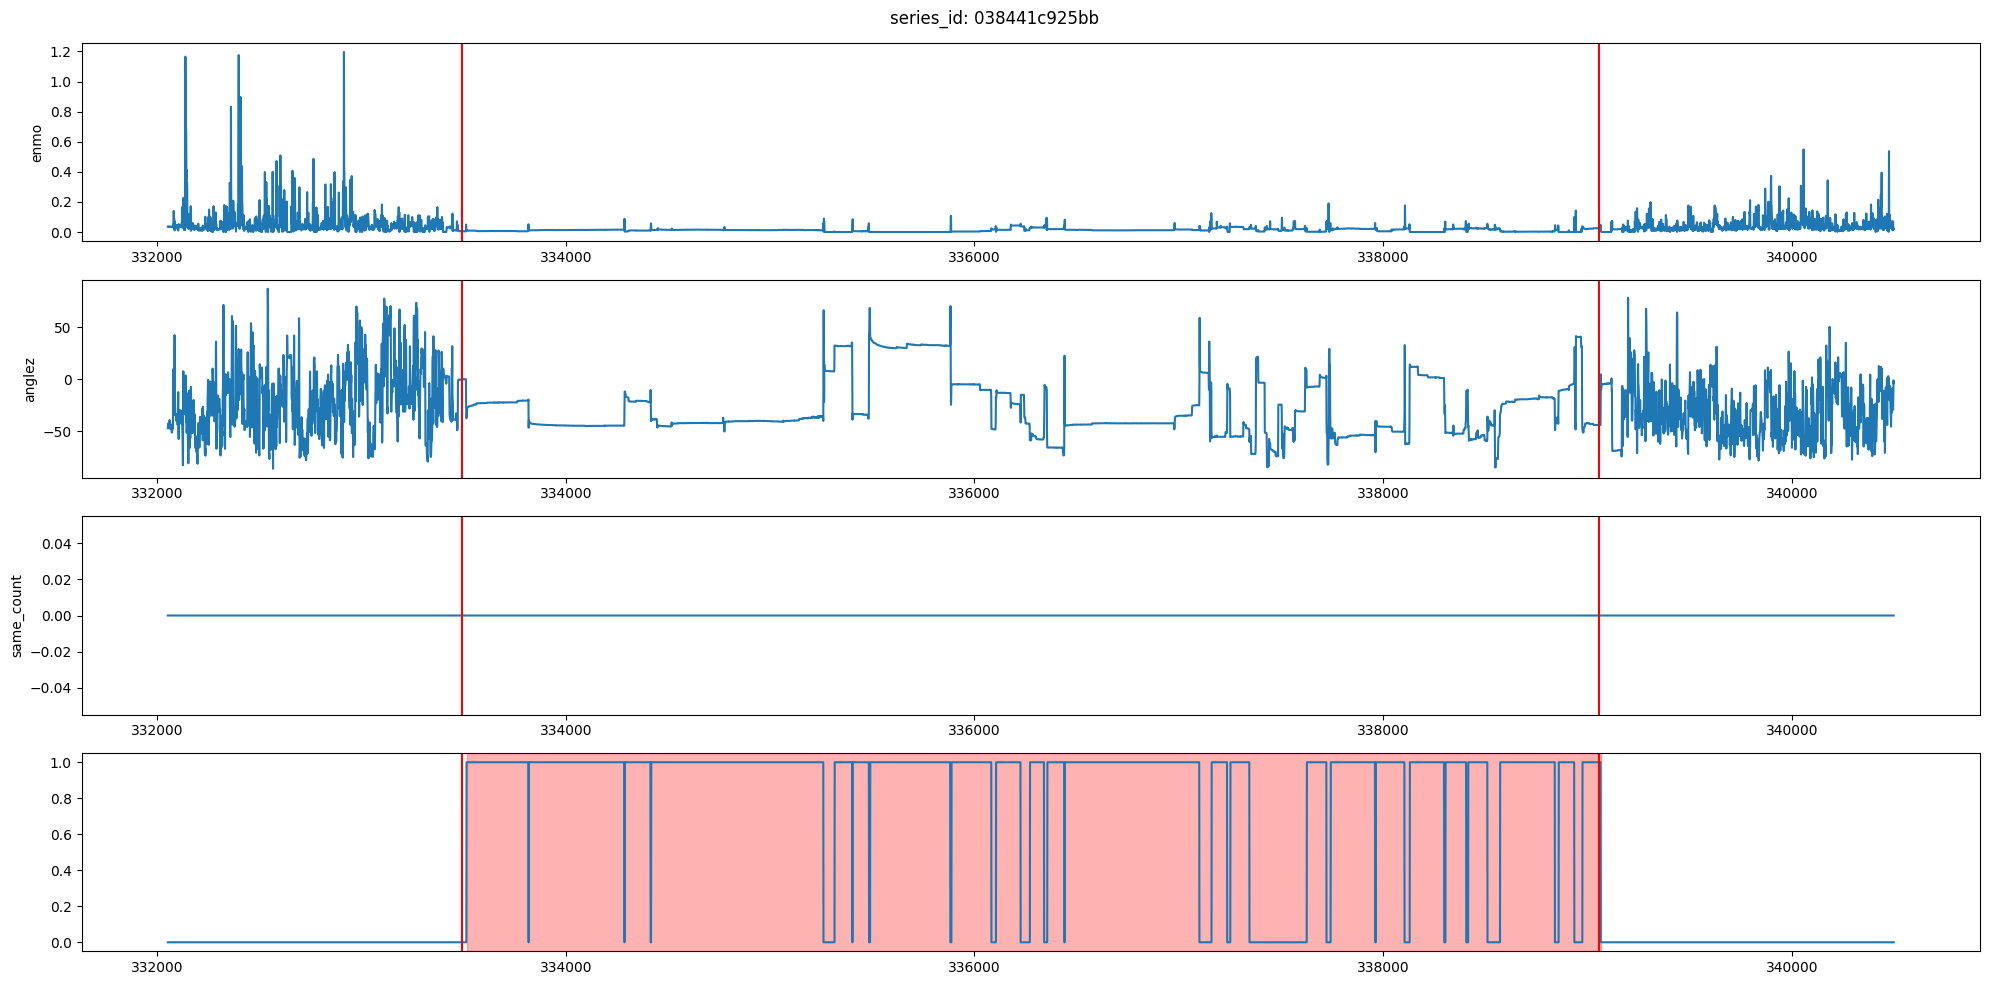

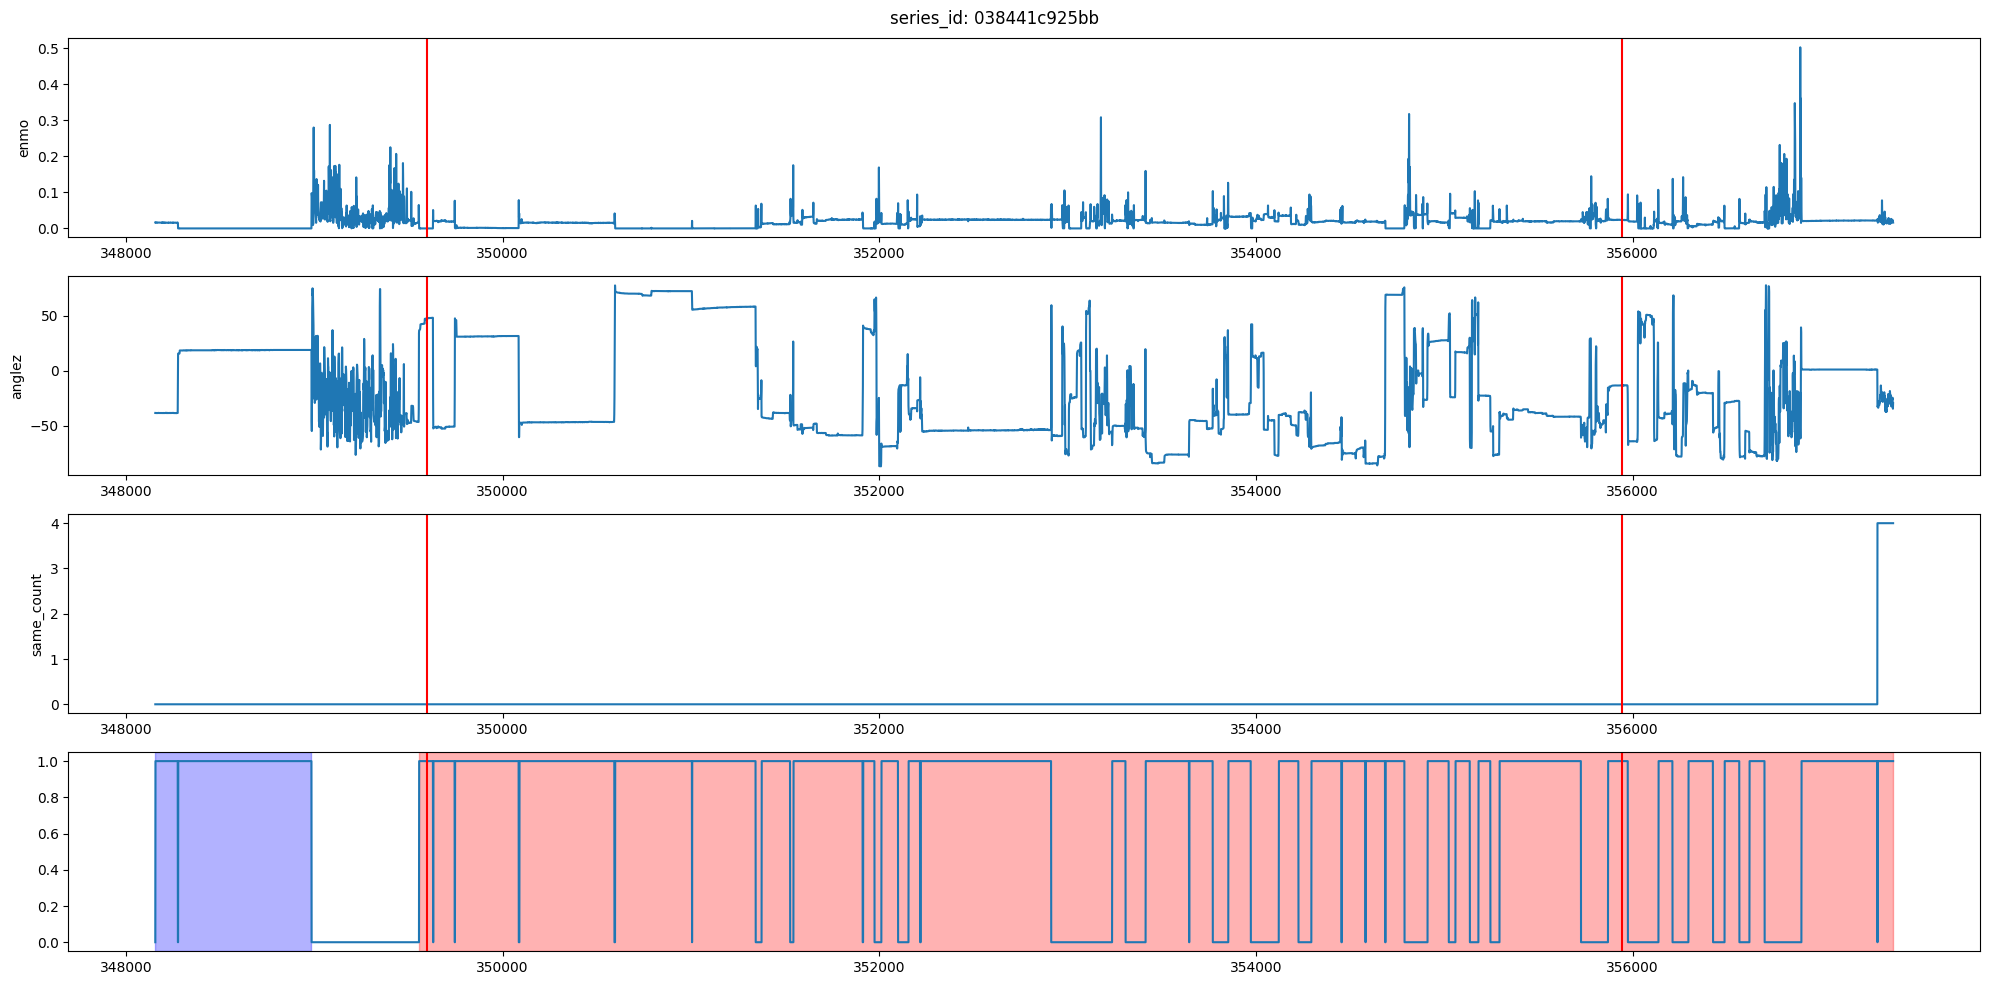

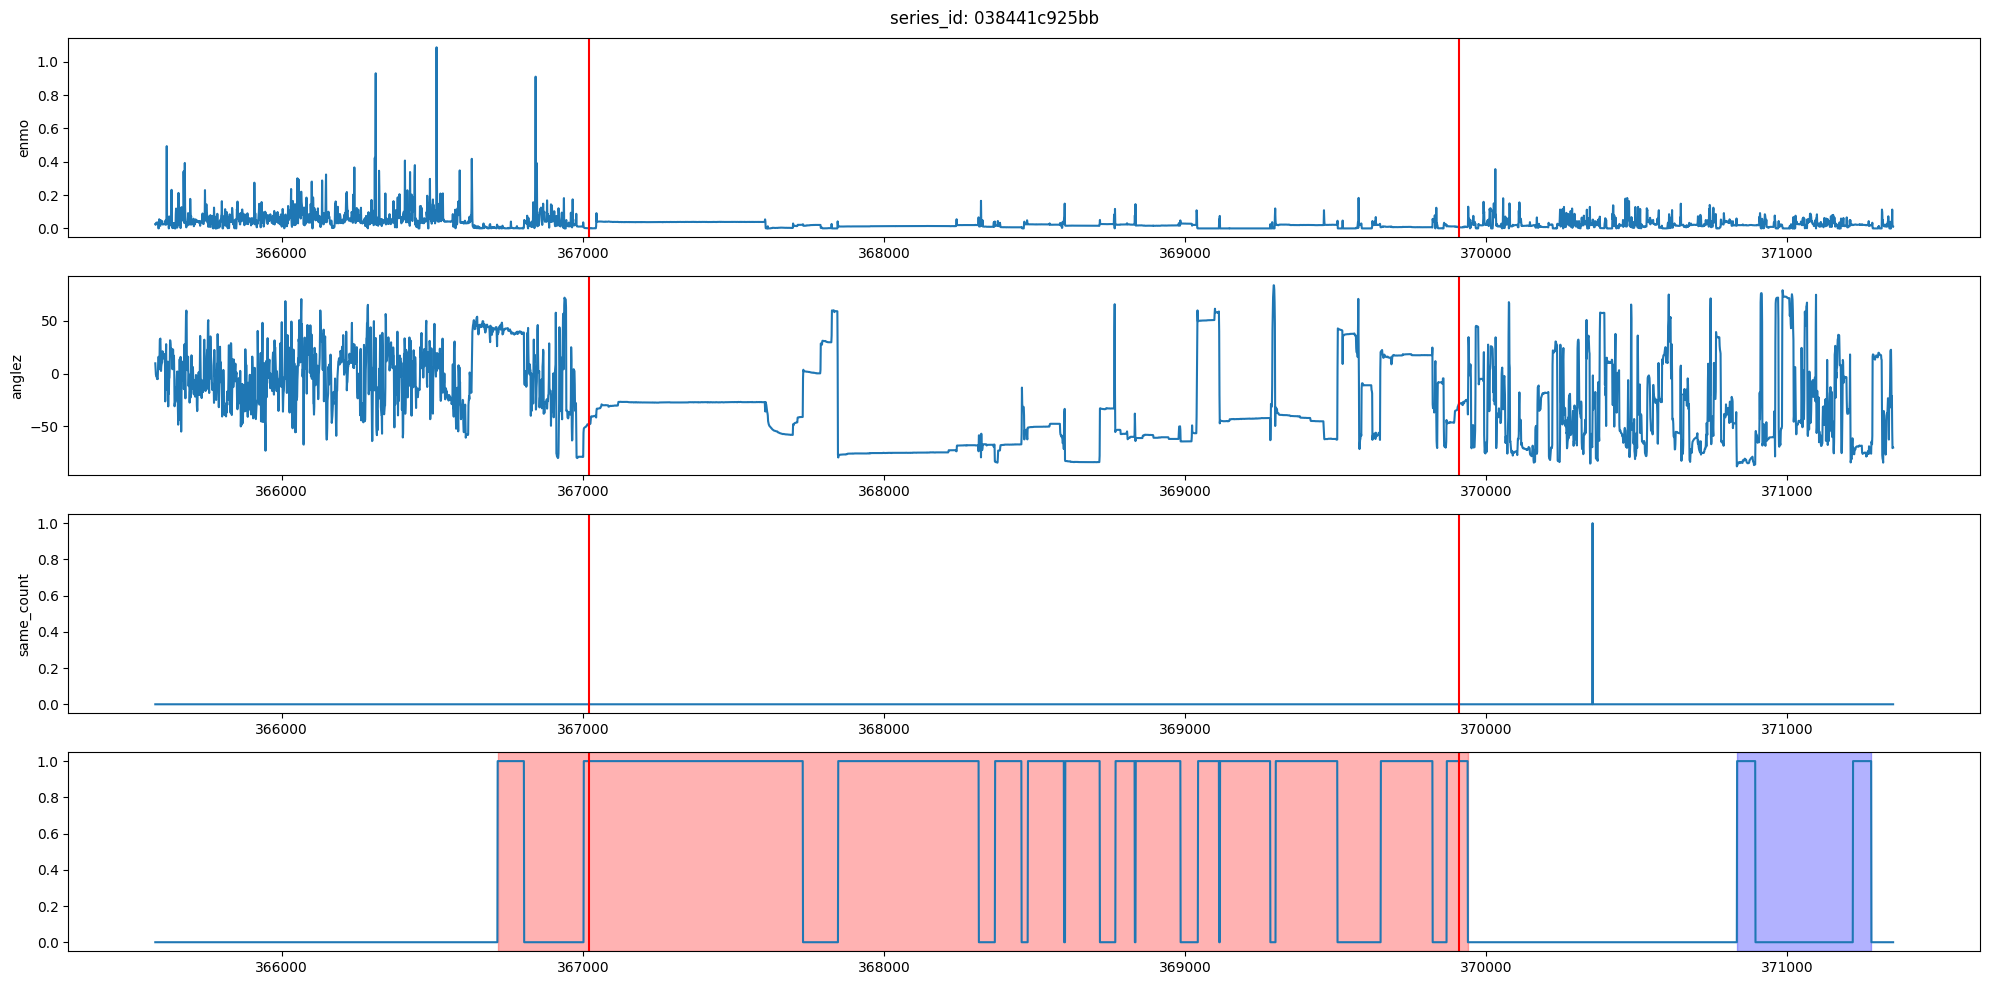

  0%|          | 0/277 [00:05<?, ?it/s]


In [42]:
dfs = []
for series_id in tqdm(labels["series_id"].unique()):
    df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{series_id}.csv")

    DAY_STEPS = 60 * 60 * 24 // 5
    n_days = int(len(df) // DAY_STEPS) + 1
    df["same_count"] = 0
    for day in range(-n_days, n_days + 1):
        if day == 0:
            continue
        df["anglez_diff"] = df["anglez"].diff(DAY_STEPS * day)
        df["anglez_diff"] = df["anglez_diff"].fillna(1)
        df["same_count"] += (df["anglez_diff"] == 0).astype(int)
            
    df["group"] = df["target"].diff().abs().cumsum()
    start_steps = df.groupby("group").head(1)["step"].values
    end_steps = df.groupby("group").tail(1)["step"].values

    for start_step, end_step in zip(start_steps, end_steps):
        MERGIN = 12 * 120 # 120min
        group_df = df[(df["step"] >= start_step - MERGIN) & (df["step"] <= end_step + MERGIN)]

        if group_df["target"].values[len(group_df) // 2] == 1:
            continue

        fig, axs = plt.subplots(4, 1, figsize=(20, 10))
        axs[0].plot(group_df["step"], group_df["enmo"])
        axs[0].axvline(start_step, color="red")
        axs[0].axvline(end_step, color="red")
        axs[0].set_ylabel("enmo")
        axs[1].plot(group_df["step"], group_df["anglez"])
        axs[1].axvline(start_step, color="red")
        axs[1].axvline(end_step, color="red")
        axs[1].set_ylabel("anglez")
        axs[2].plot(group_df["step"], group_df["same_count"])
        axs[2].axvline(start_step, color="red")
        axs[2].axvline(end_step, color="red")
        axs[2].set_ylabel("same_count")

        # 非activeな時間を検出
        group_df["anglez_diff_smaller_than_5"] = (group_df["anglez"].diff().abs() < 10).astype(int)
        group_df["angle_group"] = group_df["anglez_diff_smaller_than_5"].diff().abs().cumsum()

        gdf = group_df.groupby("angle_group")["anglez_diff_smaller_than_5"].count().reset_index()
        non_active_groups = gdf[gdf["anglez_diff_smaller_than_5"] >= 12 * 5]["angle_group"].values
        group_df["non_active"] = group_df["angle_group"].isin(non_active_groups).astype(int)
        axs[3].plot(group_df["step"], group_df["non_active"])
        axs[3].axvline(start_step, color="red")
        axs[3].axvline(end_step, color="red")

        # 非activeな時間を結合
        gdf = group_df[group_df["non_active"] == 1].groupby("angle_group")
        group_min_max = pd.concat([gdf[["step"]].min().add_prefix("start_"), gdf[["step"]].max().add_prefix("end_")], axis=1).reset_index()
        sleep_ids = [0]
        for i, (end, start) in enumerate(zip(group_min_max["end_step"].values[:-1], group_min_max["start_step"].values[1:])):
            if start - end < 12 * 30:
                sleep_ids.append(sleep_ids[-1])
            else:
                sleep_ids.append(sleep_ids[-1] + 1)
        group_min_max["sleep_id"] = sleep_ids
        starts = []
        ends = []
        durations = []
        for sleep_id, sleep_df in group_min_max.groupby("sleep_id"):
            start = sleep_df["start_step"].min()
            end = sleep_df["end_step"].max()
            starts.append(start)
            ends.append(end)
            durations.append(end - start)
        
        # 最も長い睡眠時間を取得
        max_idx = np.argmax(durations)
        max_start = starts[max_idx]
        max_end = ends[max_idx]
        for i, (start, end) in enumerate(zip(starts, ends)):
            if i == max_idx:
                axs[3].axvspan(start, end, color="red", alpha=0.3)
            else:
                axs[3].axvspan(start, end, color="blue", alpha=0.3)

        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

    break

In [28]:
# end - startが最も大きいsleep_idを

,angle_group,start_step,end_step,sleep_id
0,1.0,3553,3650,0
1,35.0,3759,3860,0
2,53.0,3920,3973,0
3,365.0,5006,5471,1
4,369.0,5478,5755,1
5,373.0,5760,6194,1
6,379.0,6205,6594,1
7,381.0,6600,6781,1
8,385.0,6794,6920,1
9,387.0,6923,6983,1
